#Check Hardware Info

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Dec 15 22:37:28 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


#Download Data (Run Only Once)

In [3]:
!pip install --upgrade --force-reinstall --no-deps kaggle

import os
os.environ['KAGGLE_USERNAME'] = "josephzheng1998"
os.environ['KAGGLE_KEY'] = "72fd2a56fcfde8d42fe037aa8d9be146"

!kaggle datasets download -d msambare/fer2013
!unzip -qq fer2013.zip
!rm fer2013.zip

     |████████████████████████████████| 61kB 6.1MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp36-none-any.whl size=73269 sha256=62e67f81e2d380882be624fa741254cf15f417178def564d2417ebdbba80404d
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
Successfully built kaggle
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10
 68% 41.0M/60.3M [00:01<00:00, 39.2MB/s]
100% 60.3M/60.3M [00:01<00:00, 53.7MB/s]


In [4]:
!pip install split-folders

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
import splitfolders
splitfolders.ratio('test', output='val_test', seed=1337, ratio=(0, 0.5, 0.5), group_prefix=None)

Copying files: 7178 files [00:00, 7967.19 files/s]


#Environment Setup

In [1]:
import os
import numpy as np
from PIL import Image

import torch
import torchvision
from torchvision import transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

import time
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
cuda = torch.cuda.is_available()
device = torch.device('cuda' if cuda else 'cpu')
print(device)

cuda


#Data Preprocessing

In [3]:
batch_size = 64
train_transform = transforms.Compose([transforms.Resize(224),
                                      transforms.RandomRotation(45),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
val_transform = transforms.Compose([transforms.Resize(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

train_dataset = ImageFolder(root='train/', transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=16, pin_memory=True)

dev_dataset = ImageFolder(root='val_test/val/', transform=val_transform)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)

test_dataset = ImageFolder(root='val_test/test/', transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)

print('train dataset: {} images {} classes'.format(len(train_dataset), len(train_dataset.classes)))
print('dev dataset: {} images {} classes'.format(len(dev_dataset), len(dev_dataset.classes)))
print('test dataset: {} images {} classes'.format(len(test_dataset), len(test_dataset.classes)))

train dataset: 28709 images 7 classes
dev dataset: 3587 images 7 classes
test dataset: 3591 images 7 classes


#General Classes and Functions

In [4]:
def train(model, train_loader, optimizer, criterion, scaler, device, epoch, empty_cache=False):
    start = time.time()
    model.train()
    avg_loss = 0.0
    train_loss = []
    accuracy = 0
    total = 0

    for batch_num, (feats, labels) in enumerate(train_loader):
        feats, labels = feats.to(device), labels.to(device)
        
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(feats.float())
            loss = criterion(outputs, labels.long())
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        avg_loss += loss.item()

        pred_labels = torch.max(F.softmax(outputs, dim=1), 1)[1]
        pred_labels = pred_labels.view(-1)
        accuracy += torch.sum(torch.eq(pred_labels, labels)).item()
        total += len(labels)
        train_loss.extend([loss.item()]*feats.size()[0])

        if batch_num % 50 == 49:
            print('Epoch: {}\tBatch: {}\tAvg-Loss: {:.4f}\tElapsed Time: {:.4f}'.
                  format(epoch+1, batch_num+1, avg_loss/50, time.time()-start))
            avg_loss = 0.0    
        
        if empty_cache:
            torch.cuda.empty_cache()
            del feats
            del labels
            del loss
        
    end = time.time()
    print('Epoch: {}\tTraining Time: {:.4f}'.format(epoch+1, end-start))
    return np.mean(train_loss), accuracy/total

In [5]:
def valid(model, val_loader, criterion, device, epoch, dataset, empty_cache=False):
    start = time.time()
    model.eval()
    test_loss = []
    accuracy = 0
    total = 0
    pred_list = []
    true_list = []

    with torch.no_grad():
        for batch_num, (feats, labels) in enumerate(val_loader):
            feats, labels = feats.to(device), labels.to(device)
            outputs = model(feats.float())
            
            pred_labels = torch.max(F.softmax(outputs, dim=1), 1)[1]
            pred_labels = pred_labels.view(-1)
            
            loss = criterion(outputs, labels.long())
            
            accuracy += torch.sum(torch.eq(pred_labels, labels)).item()
            total += len(labels)
            test_loss.extend([loss.item()]*feats.size()[0])

            pred_list.extend(pred_labels.detach().cpu().numpy())
            true_list.extend(labels.detach().cpu().numpy())

            if empty_cache:
                torch.cuda.empty_cache()
                del feats
                del labels
                del loss
    
    matrix = confusion_matrix(true_list, pred_list)
    model.train()
    end = time.time()
    print('Epoch: {}\t{} Validation Time: {:.4f}'.format(epoch+1, dataset, end-start))
    return np.mean(test_loss), accuracy/total, matrix

In [6]:
def train_model(model, model_name, train_loader, val_loader, test_loader, optimizer, criterion, scheduler, scaler, device, start_epoch, num_epochs, train_losses, train_accuracy, valid_losses, valid_accuracy, test_losses, test_accuracy, empty_cache=False):
    for epoch in range(start_epoch, num_epochs):
        print("Epoch: {}\tLearning Rate: {}".format(epoch+1, optimizer.param_groups[0]['lr']))
        
        train_loss, train_acc = train(model, train_loader, optimizer, criterion, scaler, device, epoch, empty_cache)
        print('Epoch: {}\tTrain Loss: {:.5f}\tTrain Accuracy: {:.5f}'.format(epoch+1, train_loss, train_acc))
        train_losses.append(train_loss)
        train_accuracy.append(train_acc)
        
        val_loss, val_acc, matrix = valid(model, val_loader, criterion, device, epoch, 'Validation Dataset', empty_cache)
        print('Epoch: {}\tVal Loss: {:.5f}\tVal Accuracy: {:.5f}'.format(epoch+1, val_loss, val_acc))
        valid_losses.append(val_loss)
        valid_accuracy.append(val_acc)

        test_loss, test_acc, matrix = valid(model, test_loader, criterion, device, epoch, 'Test Dataset', empty_cache)
        print('Epoch: {}\tTest Loss: {:.5f}\tTest Accuracy: {:.5f}'.format(epoch+1, test_loss, test_acc))
        test_losses.append(test_loss)
        test_accuracy.append(test_acc)
        
        scheduler.step(val_loss)

        print('Epoch: {}\tSaved Model'.format(epoch+1))
        saved_model = {
            'train_epochs': epoch + 1,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'criterion': criterion.state_dict(),
            'scheduler': scheduler.state_dict(),
            'scaler': scaler.state_dict(),
            'train_losses': train_losses,
            'train_accuracy': train_accuracy,
            'valid_losses': valid_losses,
            'valid_accuracy': valid_accuracy,
            'test_losses': test_losses,
            'test_accuracy': test_accuracy
            }
        torch.save(saved_model, '/content/gdrive/My Drive/{}.model'.format(model_name))    
    return train_losses, train_accuracy, valid_losses, valid_accuracy, test_losses, test_accuracy

In [7]:
def training_plot(a, b, c, name):
    plt.figure(1)
    plt.plot(a, 'b', label='train')
    plt.plot(b, 'g', label='valid')
    plt.plot(c, 'r', label='test')
    plt.title('Train/Valid/Test {}'.format(name))
    plt.legend()
    plt.show()

#CNN Model

In [ ]:
num_epochs = 30
num_classes = len(train_dataset.classes)

lr = 1e-2
weight_decay = 5e-4
momentum = 0.9

start_epoch = 0
train_losses = []
train_accuracy = []
valid_losses = []
valid_accuracy = []
test_losses = []
test_accuracy = []

empty_cache = True

In [ ]:
model_name = 'DenseNet121'
model = models.densenet121(pretrained=True)
model.classifier = nn.Linear(1024, num_classes)
model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=1, verbose=True)
scaler = torch.cuda.amp.GradScaler()

In [ ]:
if os.path.exists('/content/gdrive/My Drive/{}.model'.format(model_name)):
    print('Found pretrained model!')
    saved_model = torch.load('/content/gdrive/My Drive/{}.model'.format(model_name))
    start_epoch = saved_model['train_epochs']
    model.load_state_dict(saved_model['model'])
    criterion.load_state_dict(saved_model['criterion'])
    optimizer.load_state_dict(saved_model['optimizer'])
    scheduler.load_state_dict(saved_model['scheduler'])
    scaler.load_state_dict(saved_model['scaler'])
    train_losses = saved_model['train_losses']
    train_accuracy = saved_model['train_accuracy']
    valid_losses = saved_model['valid_losses']
    valid_accuracy = saved_model['valid_accuracy']
    test_losses = saved_model['test_losses']
    test_accuracy = saved_model['test_accuracy']

Found pretrained model!


In [ ]:
print('Training', model_name)
train_losses, train_accuracy, valid_losses, valid_accuracy, test_losses, test_accuracy = train_model(model, model_name,
                                                                                                     train_loader, dev_loader, test_loader,
                                                                                                     optimizer, criterion, scheduler, scaler,
                                                                                                     device, start_epoch, num_epochs,
                                                                                                     train_losses, train_accuracy,
                                                                                                     valid_losses, valid_accuracy,
                                                                                                     test_losses, test_accuracy, empty_cache)

Training DenseNet121


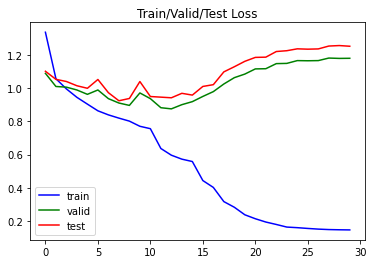

In [ ]:
training_plot(train_losses, valid_losses, test_losses, 'Loss')

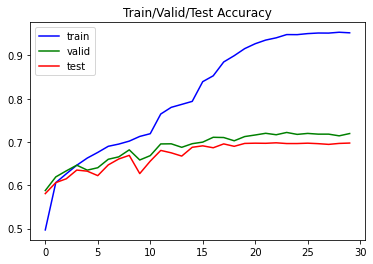

In [ ]:
training_plot(train_accuracy, valid_accuracy, test_accuracy, 'Accuracy')

#Plot Functions

In [8]:
def make_plots(a, b, model_name, plot_type):
    plt.figure(1)
    plt.plot(range(1, len(a) + 1), a, 'b', label='train')
    plt.plot(range(1, len(b) + 1), b, 'g', label='valid')
    plt.title('{} Train/Valid {}'.format(model_name, plot_type))
    plt.xlabel('Epochs')
    plt.ylabel(plot_type)
    plt.legend()
    plt.savefig('/content/gdrive/My Drive/{}_{}.png'.format(model_name, '_'.join(plot_type.lower().split())))
    plt.show()

In [9]:
def plot_matrix(matrix, dataset, model_name):
    emotion_list = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    matrix_df = pd.DataFrame(matrix, index=emotion_list, columns=emotion_list)
    plt.figure(figsize=(12,8))
    ax = sns.heatmap(matrix_df, cmap='YlGnBu', annot=True, fmt='d', annot_kws={'size': 16}).set_title('{} Confusion Matrix ({})'.format(model_name, dataset))
    plt.savefig('/content/gdrive/My Drive/{}_{}_matrix.png'.format('_'.join(model_name.split()), dataset.lower()))
    plt.show()

#Load Models

In [10]:
num_classes = 7

In [11]:
train_accuracy = {}
valid_accuracy = {}
test_accuracy = {}
model_list = {}

In [12]:
criterion = nn.CrossEntropyLoss()
empty_cache = True

Found pretrained model!
ResNet18 Test Loss: 1.0618306175475996


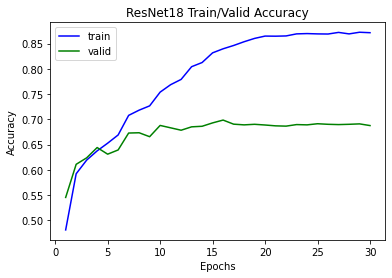

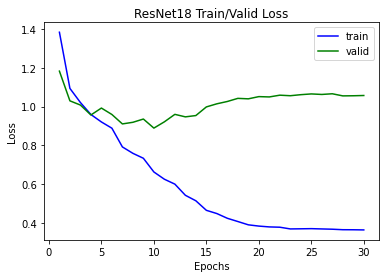

Epoch: 1	Validation Dataset Validation Time: 5.2415


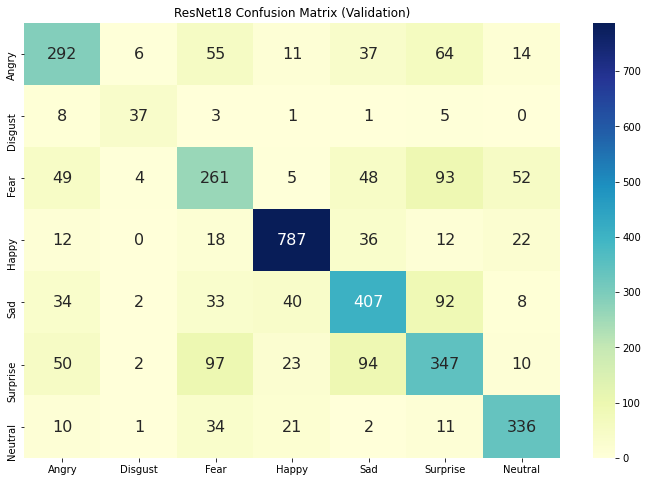

Epoch: 1	Test Dataset Validation Time: 5.1556


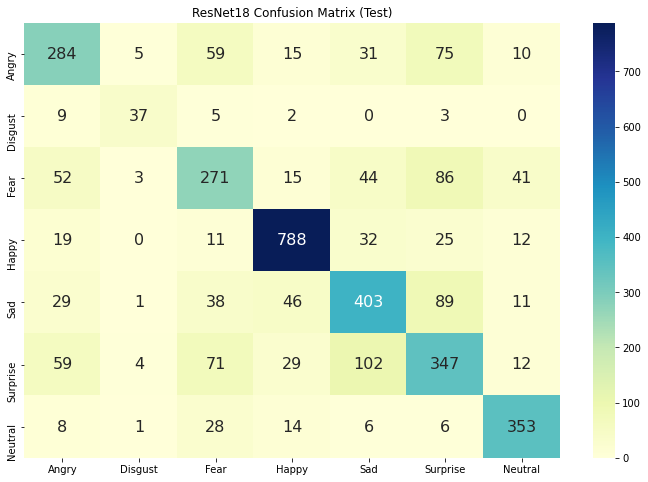

In [13]:
model_name = 'ResNet18'
resnet18 = models.resnet18()
resnet18.fc = nn.Linear(512, num_classes)
if os.path.exists('/content/gdrive/My Drive/{}.model'.format(model_name)):
    print('Found pretrained model!')
    saved_model = torch.load('/content/gdrive/My Drive/{}.model'.format(model_name))
    resnet18.load_state_dict(saved_model['model'])
    model_list[model_name] = resnet18
    train_loss = saved_model['train_losses']
    valid_loss = saved_model['valid_losses']
    test_loss = saved_model['test_losses']
    train_accuracy[model_name] = saved_model['train_accuracy']
    valid_accuracy[model_name] = saved_model['valid_accuracy']
    test_accuracy[model_name] = saved_model['test_accuracy']
resnet18.to(device)
resnet18.eval()
print('{} Test Loss: {}'.format(model_name, test_loss[-1]))
make_plots(train_accuracy[model_name], valid_accuracy[model_name], model_name, 'Accuracy')
make_plots(train_loss, valid_loss, model_name, 'Loss')
loss, acc, matrix = valid(resnet18, dev_loader, criterion, device, 0, 'Validation Dataset', empty_cache)
plot_matrix(matrix, 'Validation', model_name)
loss, acc, matrix = valid(resnet18, test_loader, criterion, device, 0, 'Test Dataset', empty_cache)
plot_matrix(matrix, 'Test', model_name)

Found pretrained model!
ResNet34 Test Loss: 1.2317933945129986


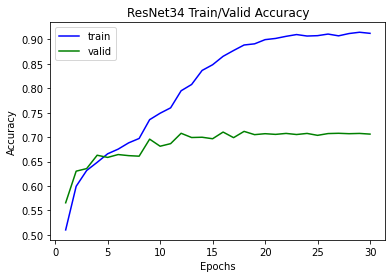

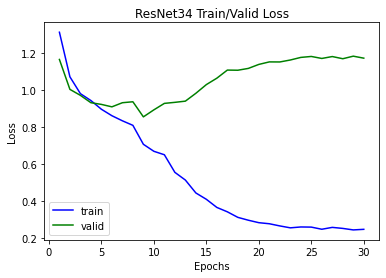

Epoch: 1	Validation Dataset Validation Time: 5.5495


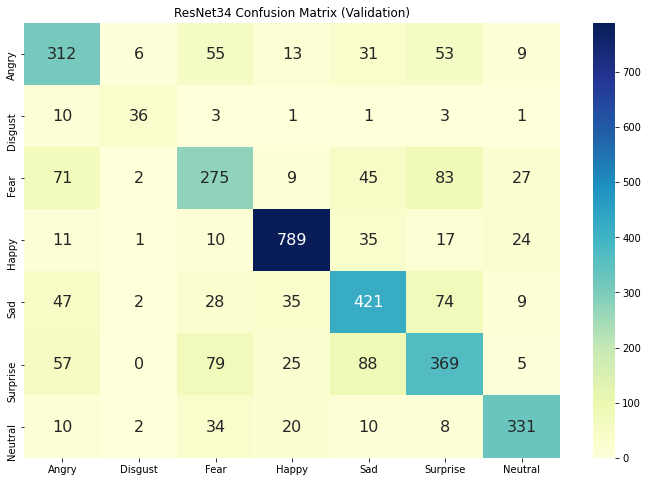

Epoch: 1	Test Dataset Validation Time: 5.5003


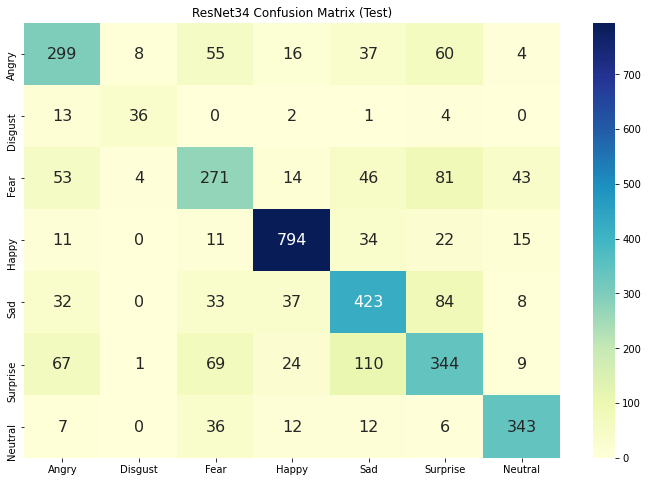

In [14]:
model_name = 'ResNet34'
resnet34 = models.resnet34()
resnet34.fc = nn.Linear(512, num_classes)
if os.path.exists('/content/gdrive/My Drive/{}.model'.format(model_name)):
    print('Found pretrained model!')
    saved_model = torch.load('/content/gdrive/My Drive/{}.model'.format(model_name))
    resnet34.load_state_dict(saved_model['model'])
    model_list[model_name] = resnet34
    train_loss = saved_model['train_losses']
    valid_loss = saved_model['valid_losses']
    test_loss = saved_model['test_losses']
    train_accuracy[model_name] = saved_model['train_accuracy']
    valid_accuracy[model_name] = saved_model['valid_accuracy']
    test_accuracy[model_name] = saved_model['test_accuracy']
resnet34.to(device)
resnet34.eval()
print('{} Test Loss: {}'.format(model_name, test_loss[-1]))
make_plots(train_accuracy[model_name], valid_accuracy[model_name], model_name, 'Accuracy')
make_plots(train_loss, valid_loss, model_name, 'Loss')
loss, acc, matrix = valid(resnet34, dev_loader, criterion, device, 0, 'Validation Dataset', empty_cache)
plot_matrix(matrix, 'Validation', model_name)
loss, acc, matrix = valid(resnet34, test_loader, criterion, device, 0, 'Test Dataset', empty_cache)
plot_matrix(matrix, 'Test', model_name)

Found pretrained model!
ResNet50 Test Loss: 1.3046927751355502


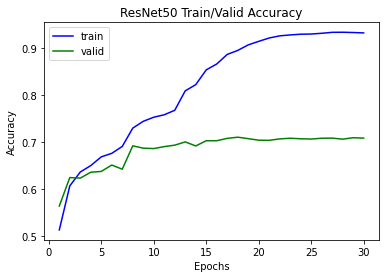

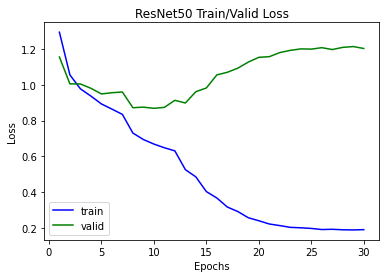

Epoch: 1	Validation Dataset Validation Time: 6.9367


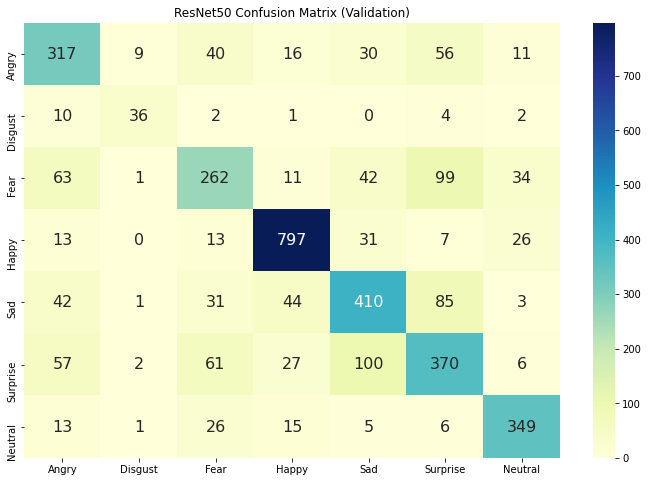

Epoch: 1	Test Dataset Validation Time: 6.7597


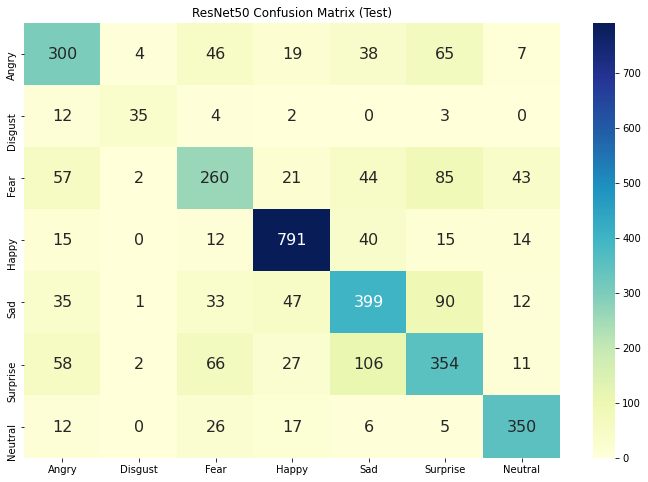

In [15]:
model_name = 'ResNet50'
resnet50 = models.resnet50()
resnet50.fc = nn.Linear(2048, num_classes)
if os.path.exists('/content/gdrive/My Drive/{}.model'.format(model_name)):
    print('Found pretrained model!')
    saved_model = torch.load('/content/gdrive/My Drive/{}.model'.format(model_name))
    resnet50.load_state_dict(saved_model['model'])
    model_list[model_name] = resnet50
    train_loss = saved_model['train_losses']
    valid_loss = saved_model['valid_losses']
    test_loss = saved_model['test_losses']
    train_accuracy[model_name] = saved_model['train_accuracy']
    valid_accuracy[model_name] = saved_model['valid_accuracy']
    test_accuracy[model_name] = saved_model['test_accuracy']
resnet50.to(device)
resnet50.eval()
print('{} Test Loss: {}'.format(model_name, test_loss[-1]))
make_plots(train_accuracy[model_name], valid_accuracy[model_name], model_name, 'Accuracy')
make_plots(train_loss, valid_loss, model_name, 'Loss')
loss, acc, matrix = valid(resnet50, dev_loader, criterion, device, 0, 'Validation Dataset', empty_cache)
plot_matrix(matrix, 'Validation', model_name)
loss, acc, matrix = valid(resnet50, test_loader, criterion, device, 0, 'Test Dataset', empty_cache)
plot_matrix(matrix, 'Test', model_name)

Found pretrained model!
ResNet101 Test Loss: 1.3161555383239274


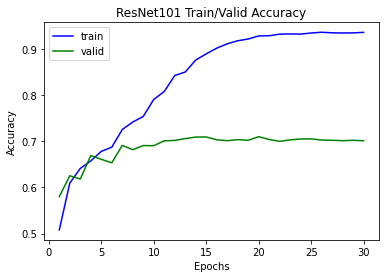

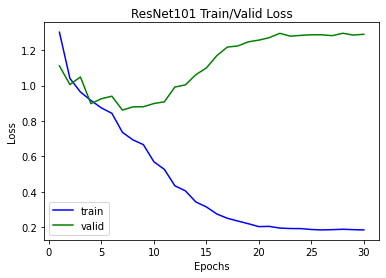

Epoch: 1	Validation Dataset Validation Time: 8.6568


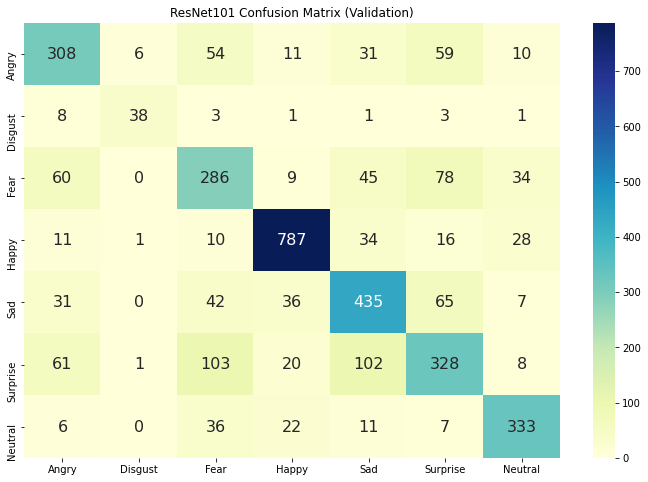

Epoch: 1	Test Dataset Validation Time: 8.7588


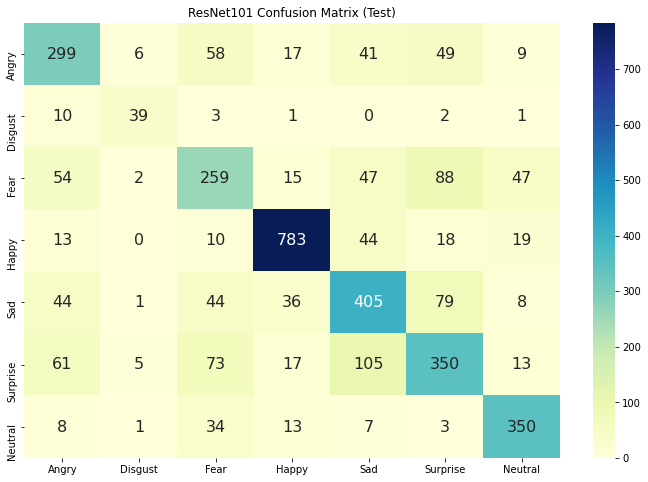

In [16]:
model_name = 'ResNet101'
resnet101 = models.resnet101()
resnet101.fc = nn.Linear(2048, num_classes)
if os.path.exists('/content/gdrive/My Drive/{}.model'.format(model_name)):
    print('Found pretrained model!')
    saved_model = torch.load('/content/gdrive/My Drive/{}.model'.format(model_name))
    resnet101.load_state_dict(saved_model['model'])
    model_list[model_name] = resnet101
    train_loss = saved_model['train_losses']
    valid_loss = saved_model['valid_losses']
    test_loss = saved_model['test_losses']
    train_accuracy[model_name] = saved_model['train_accuracy']
    valid_accuracy[model_name] = saved_model['valid_accuracy']
    test_accuracy[model_name] = saved_model['test_accuracy']
resnet101.to(device)
resnet101.eval()
print('{} Test Loss: {}'.format(model_name, test_loss[-1]))
make_plots(train_accuracy[model_name], valid_accuracy[model_name], model_name, 'Accuracy')
make_plots(train_loss, valid_loss, model_name, 'Loss')
loss, acc, matrix = valid(resnet101, dev_loader, criterion, device, 0, 'Validation Dataset', empty_cache)
plot_matrix(matrix, 'Validation', model_name)
loss, acc, matrix = valid(resnet101, test_loader, criterion, device, 0, 'Test Dataset', empty_cache)
plot_matrix(matrix, 'Test', model_name)

Found pretrained model!
ResNet152 Test Loss: 1.507793063242367


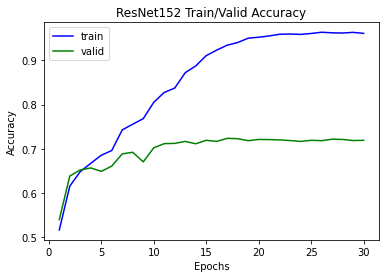

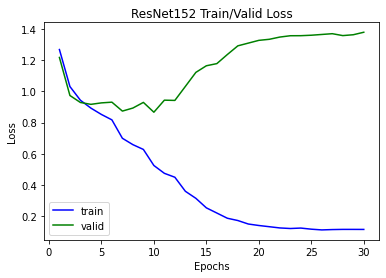

Epoch: 1	Validation Dataset Validation Time: 10.9441


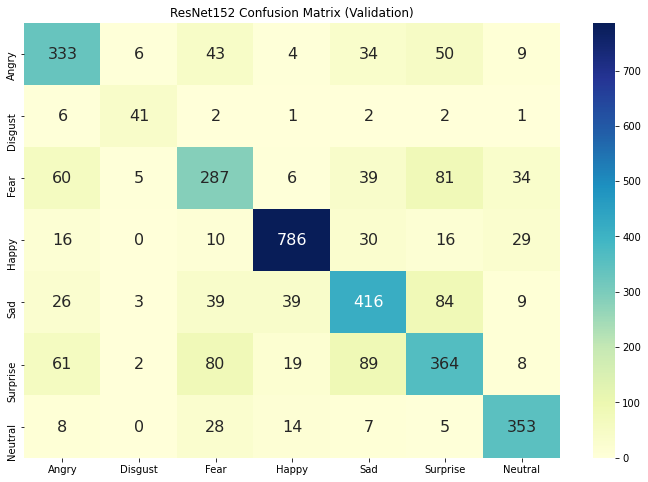

Epoch: 1	Test Dataset Validation Time: 10.6874


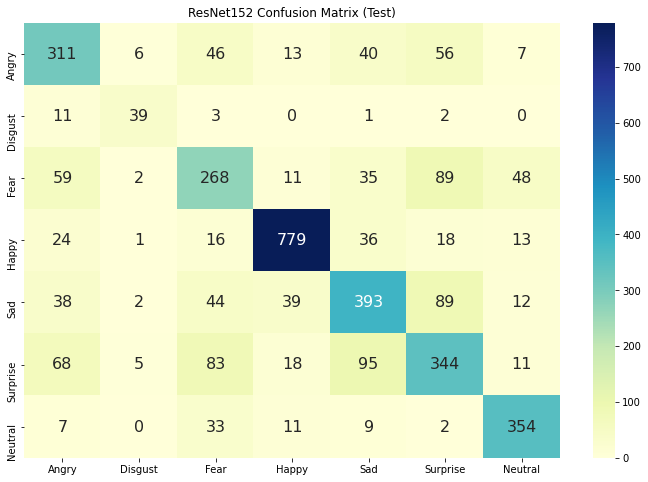

In [17]:
model_name = 'ResNet152'
resnet152 = models.resnet152()
resnet152.fc = nn.Linear(2048, num_classes)
if os.path.exists('/content/gdrive/My Drive/{}.model'.format(model_name)):
    print('Found pretrained model!')
    saved_model = torch.load('/content/gdrive/My Drive/{}.model'.format(model_name))
    resnet152.load_state_dict(saved_model['model'])
    model_list[model_name] = resnet152
    train_loss = saved_model['train_losses']
    valid_loss = saved_model['valid_losses']
    test_loss = saved_model['test_losses']
    train_accuracy[model_name] = saved_model['train_accuracy']
    valid_accuracy[model_name] = saved_model['valid_accuracy']
    test_accuracy[model_name] = saved_model['test_accuracy']
resnet152.to(device)
resnet152.eval()
print('{} Test Loss: {}'.format(model_name, test_loss[-1]))
make_plots(train_accuracy[model_name], valid_accuracy[model_name], model_name, 'Accuracy')
make_plots(train_loss, valid_loss, model_name, 'Loss')
loss, acc, matrix = valid(resnet152, dev_loader, criterion, device, 0, 'Validation Dataset', empty_cache)
plot_matrix(matrix, 'Validation', model_name)
loss, acc, matrix = valid(resnet152, test_loader, criterion, device, 0, 'Test Dataset', empty_cache)
plot_matrix(matrix, 'Test', model_name)

Found pretrained model!
ResNeXt50 Test Loss: 1.4902153422460023


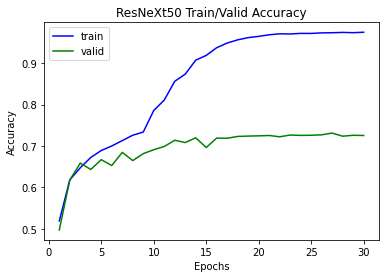

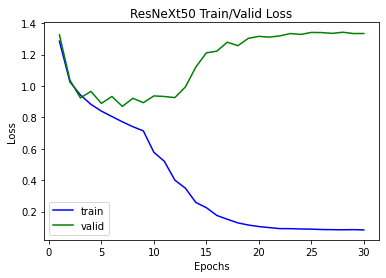

Epoch: 1	Validation Dataset Validation Time: 7.7909


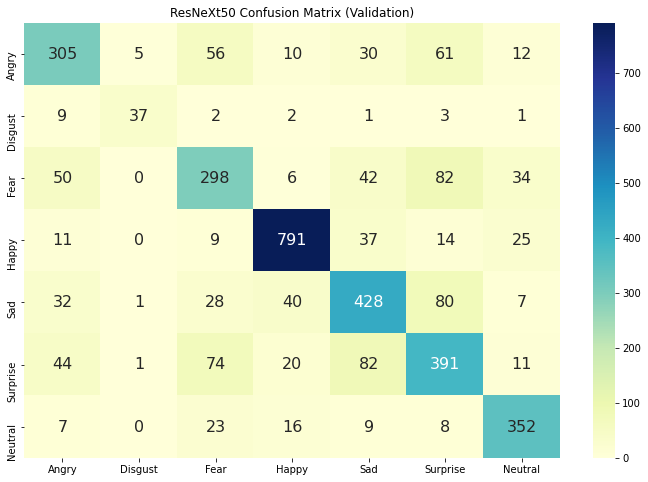

Epoch: 1	Test Dataset Validation Time: 7.6713


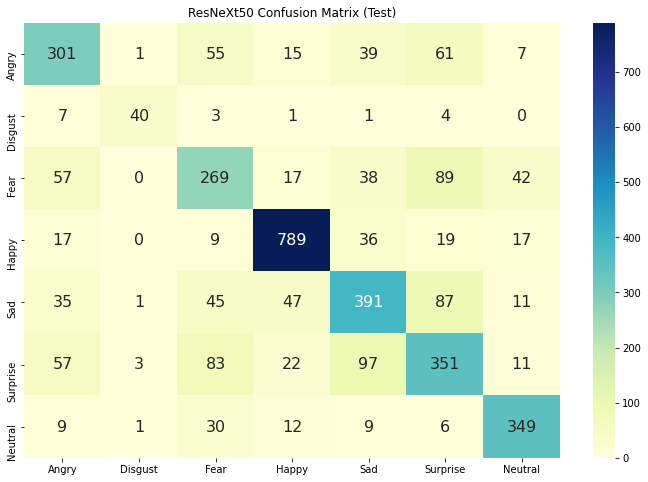

In [18]:
model_name = 'ResNeXt50'
resnext50 = models.resnext50_32x4d()
resnext50.fc = nn.Linear(2048, num_classes)
if os.path.exists('/content/gdrive/My Drive/{}.model'.format(model_name)):
    print('Found pretrained model!')
    saved_model = torch.load('/content/gdrive/My Drive/{}.model'.format(model_name))
    resnext50.load_state_dict(saved_model['model'])
    model_list[model_name] = resnext50
    train_loss = saved_model['train_losses']
    valid_loss = saved_model['valid_losses']
    test_loss = saved_model['test_losses']
    train_accuracy[model_name] = saved_model['train_accuracy']
    valid_accuracy[model_name] = saved_model['valid_accuracy']
    test_accuracy[model_name] = saved_model['test_accuracy']
resnext50.to(device)
resnext50.eval()
print('{} Test Loss: {}'.format(model_name, test_loss[-1]))
make_plots(train_accuracy[model_name], valid_accuracy[model_name], model_name, 'Accuracy')
make_plots(train_loss, valid_loss, model_name, 'Loss')
loss, acc, matrix = valid(resnext50, dev_loader, criterion, device, 0, 'Validation Dataset', empty_cache)
plot_matrix(matrix, 'Validation', model_name)
loss, acc, matrix = valid(resnext50, test_loader, criterion, device, 0, 'Test Dataset', empty_cache)
plot_matrix(matrix, 'Test', model_name)

Found pretrained model!
ResNeXt101 Test Loss: 1.7140026951493477


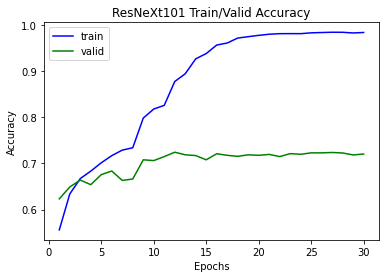

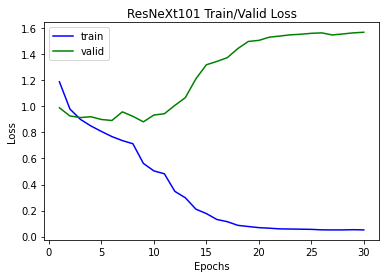

Epoch: 1	Validation Dataset Validation Time: 15.6547


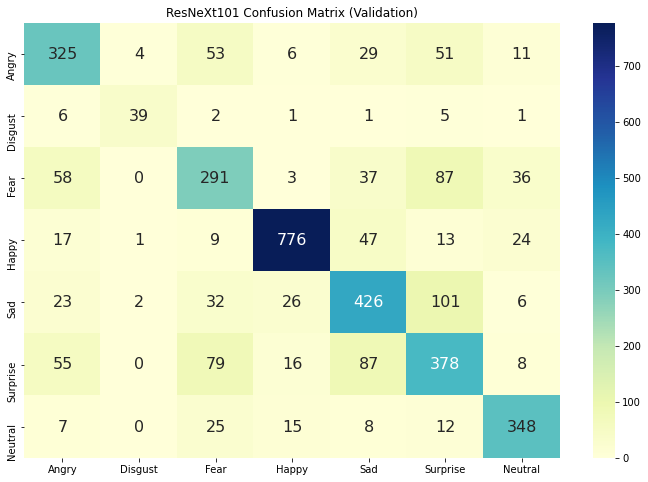

Epoch: 1	Test Dataset Validation Time: 16.5960


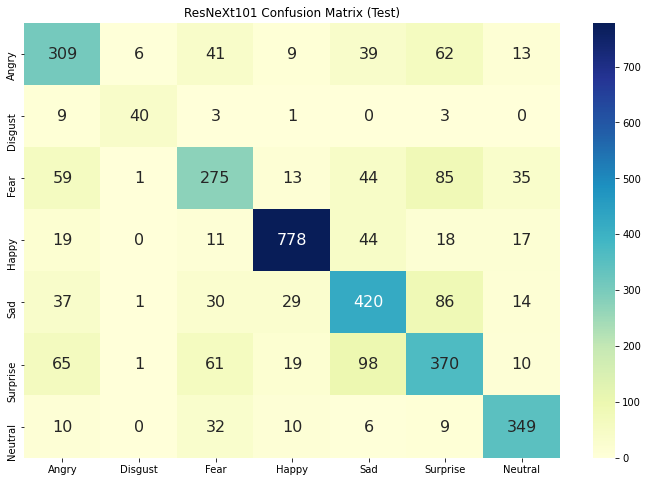

In [19]:
model_name = 'ResNeXt101'
resnext101 = models.resnext101_32x8d()
resnext101.fc = nn.Linear(2048, num_classes)
if os.path.exists('/content/gdrive/My Drive/{}.model'.format(model_name)):
    print('Found pretrained model!')
    saved_model = torch.load('/content/gdrive/My Drive/{}.model'.format(model_name))
    resnext101.load_state_dict(saved_model['model'])
    model_list[model_name] = resnext101
    train_loss = saved_model['train_losses']
    valid_loss = saved_model['valid_losses']
    test_loss = saved_model['test_losses']
    train_accuracy[model_name] = saved_model['train_accuracy']
    valid_accuracy[model_name] = saved_model['valid_accuracy']
    test_accuracy[model_name] = saved_model['test_accuracy']
resnext101.to(device)
resnext101.eval()
print('{} Test Loss: {}'.format(model_name, test_loss[-1]))
make_plots(train_accuracy[model_name], valid_accuracy[model_name], model_name, 'Accuracy')
make_plots(train_loss, valid_loss, model_name, 'Loss')
loss, acc, matrix = valid(resnext101, dev_loader, criterion, device, 0, 'Validation Dataset', empty_cache)
plot_matrix(matrix, 'Validation', model_name)
loss, acc, matrix = valid(resnext101, test_loader, criterion, device, 0, 'Test Dataset', empty_cache)
plot_matrix(matrix, 'Test', model_name)

Found pretrained model!
Wide_ResNet50 Test Loss: 1.338389788728609


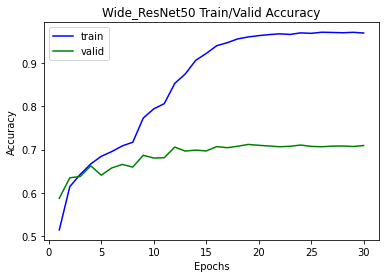

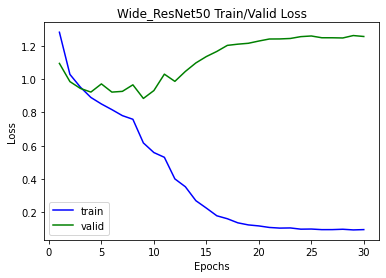

Epoch: 1	Validation Dataset Validation Time: 9.1721


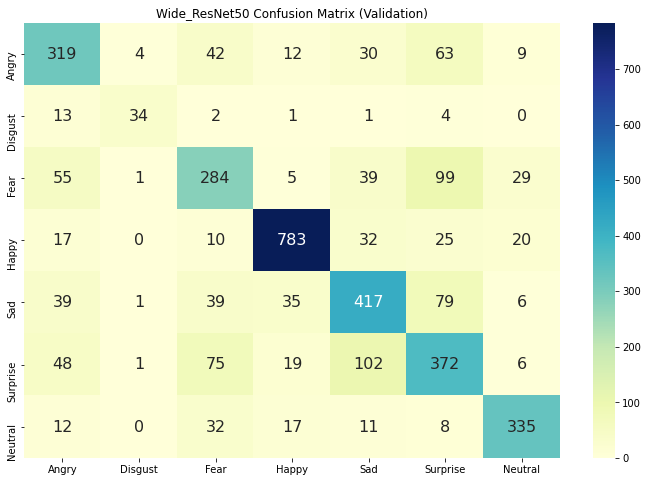

Epoch: 1	Test Dataset Validation Time: 8.8971


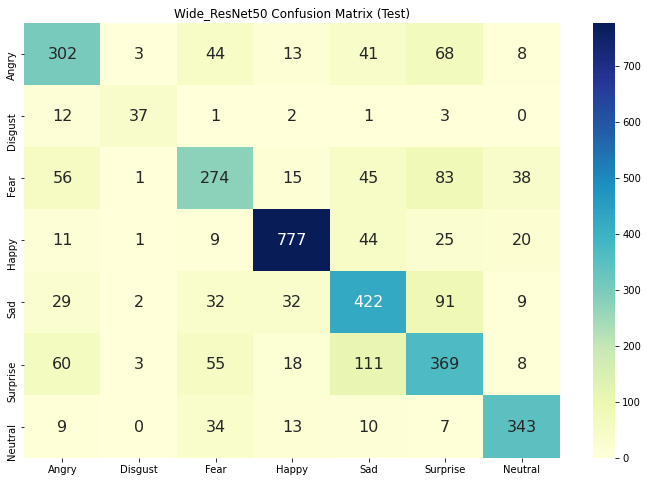

In [20]:
model_name = 'Wide_ResNet50'
wide_resnet50 = models.wide_resnet50_2()
wide_resnet50.fc = nn.Linear(2048, num_classes)
if os.path.exists('/content/gdrive/My Drive/{}.model'.format(model_name)):
    print('Found pretrained model!')
    saved_model = torch.load('/content/gdrive/My Drive/{}.model'.format(model_name))
    wide_resnet50.load_state_dict(saved_model['model'])
    model_list[model_name] = wide_resnet50
    train_loss = saved_model['train_losses']
    valid_loss = saved_model['valid_losses']
    test_loss = saved_model['test_losses']
    train_accuracy[model_name] = saved_model['train_accuracy']
    valid_accuracy[model_name] = saved_model['valid_accuracy']
    test_accuracy[model_name] = saved_model['test_accuracy']
wide_resnet50.to(device)
wide_resnet50.eval()
print('{} Test Loss: {}'.format(model_name, test_loss[-1]))
make_plots(train_accuracy[model_name], valid_accuracy[model_name], model_name, 'Accuracy')
make_plots(train_loss, valid_loss, model_name, 'Loss')
loss, acc, matrix = valid(wide_resnet50, dev_loader, criterion, device, 0, 'Validation Dataset', empty_cache)
plot_matrix(matrix, 'Validation', model_name)
loss, acc, matrix = valid(wide_resnet50, test_loader, criterion, device, 0, 'Test Dataset', empty_cache)
plot_matrix(matrix, 'Test', model_name)

Found pretrained model!
Wide_ResNet101 Test Loss: 1.2946087045860104


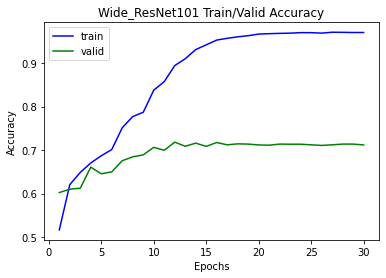

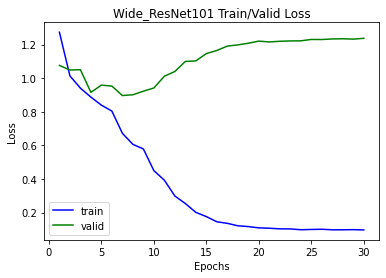

Epoch: 1	Validation Dataset Validation Time: 13.2929


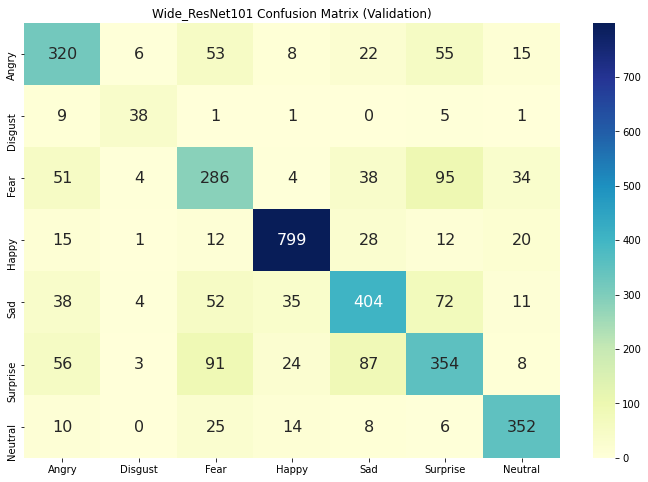

Epoch: 1	Test Dataset Validation Time: 13.0625


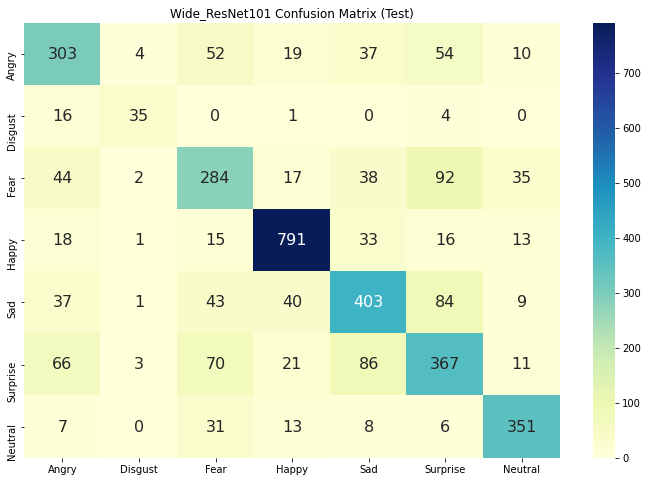

In [21]:
model_name = 'Wide_ResNet101'
wide_resnet101 = models.wide_resnet101_2()
wide_resnet101.fc = nn.Linear(2048, num_classes)
if os.path.exists('/content/gdrive/My Drive/{}.model'.format(model_name)):
    print('Found pretrained model!')
    saved_model = torch.load('/content/gdrive/My Drive/{}.model'.format(model_name))
    wide_resnet101.load_state_dict(saved_model['model'])
    model_list[model_name] = wide_resnet101
    train_loss = saved_model['train_losses']
    valid_loss = saved_model['valid_losses']
    test_loss = saved_model['test_losses']
    train_accuracy[model_name] = saved_model['train_accuracy']
    valid_accuracy[model_name] = saved_model['valid_accuracy']
    test_accuracy[model_name] = saved_model['test_accuracy']
wide_resnet101.to(device)
wide_resnet101.eval()
print('{} Test Loss: {}'.format(model_name, test_loss[-1]))
make_plots(train_accuracy[model_name], valid_accuracy[model_name], model_name, 'Accuracy')
make_plots(train_loss, valid_loss, model_name, 'Loss')
loss, acc, matrix = valid(wide_resnet101, dev_loader, criterion, device, 0, 'Validation Dataset', empty_cache)
plot_matrix(matrix, 'Validation', model_name)
loss, acc, matrix = valid(wide_resnet101, test_loader, criterion, device, 0, 'Test Dataset', empty_cache)
plot_matrix(matrix, 'Test', model_name)

Found pretrained model!
DenseNet121 Test Loss: 1.25187583525378


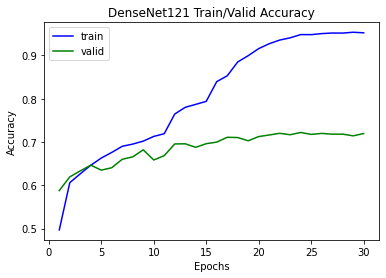

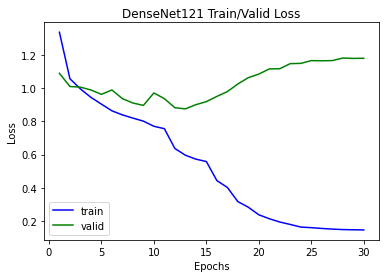

Epoch: 1	Validation Dataset Validation Time: 7.5663


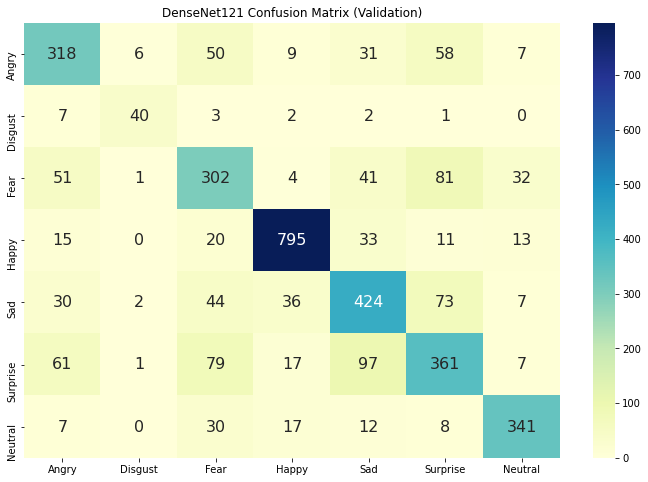

Epoch: 1	Test Dataset Validation Time: 7.6830


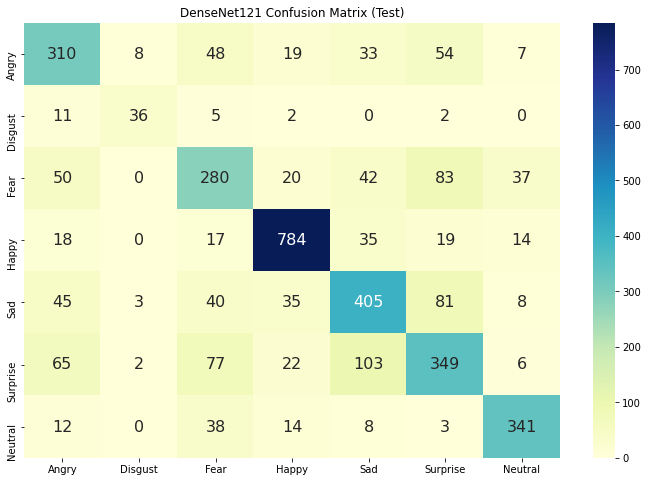

In [22]:
model_name = 'DenseNet121'
densenet121 = models.densenet121()
densenet121.classifier = nn.Linear(1024, num_classes)
if os.path.exists('/content/gdrive/My Drive/{}.model'.format(model_name)):
    print('Found pretrained model!')
    saved_model = torch.load('/content/gdrive/My Drive/{}.model'.format(model_name))
    densenet121.load_state_dict(saved_model['model'])
    model_list[model_name] = densenet121
    train_loss = saved_model['train_losses']
    valid_loss = saved_model['valid_losses']
    test_loss = saved_model['test_losses']
    train_accuracy[model_name] = saved_model['train_accuracy']
    valid_accuracy[model_name] = saved_model['valid_accuracy']
    test_accuracy[model_name] = saved_model['test_accuracy']
densenet121.to(device)
densenet121.eval()
print('{} Test Loss: {}'.format(model_name, test_loss[-1]))
make_plots(train_accuracy[model_name], valid_accuracy[model_name], model_name, 'Accuracy')
make_plots(train_loss, valid_loss, model_name, 'Loss')
loss, acc, matrix = valid(densenet121, dev_loader, criterion, device, 0, 'Validation Dataset', empty_cache)
plot_matrix(matrix, 'Validation', model_name)
loss, acc, matrix = valid(densenet121, test_loader, criterion, device, 0, 'Test Dataset', empty_cache)
plot_matrix(matrix, 'Test', model_name)

Found pretrained model!
DenseNet161 Test Loss: 1.2807263739093768


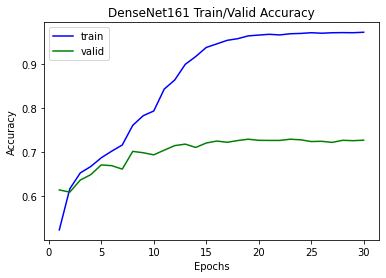

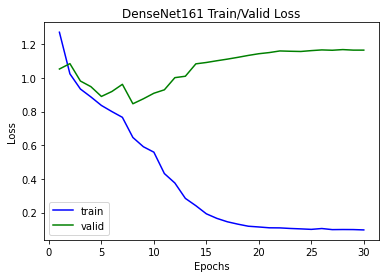

Epoch: 1	Validation Dataset Validation Time: 11.7436


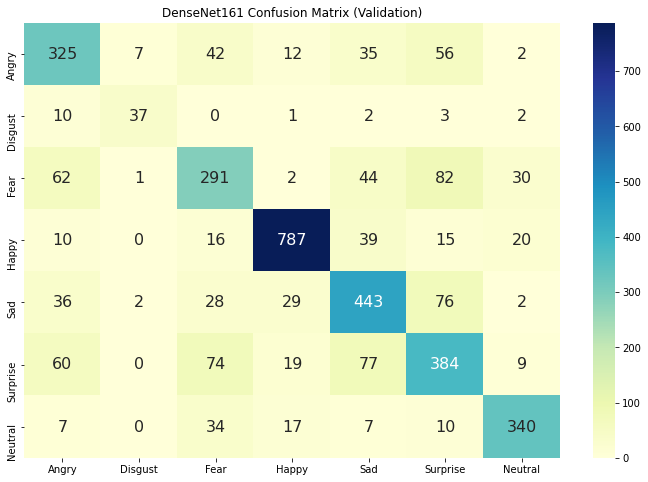

Epoch: 1	Test Dataset Validation Time: 11.7083


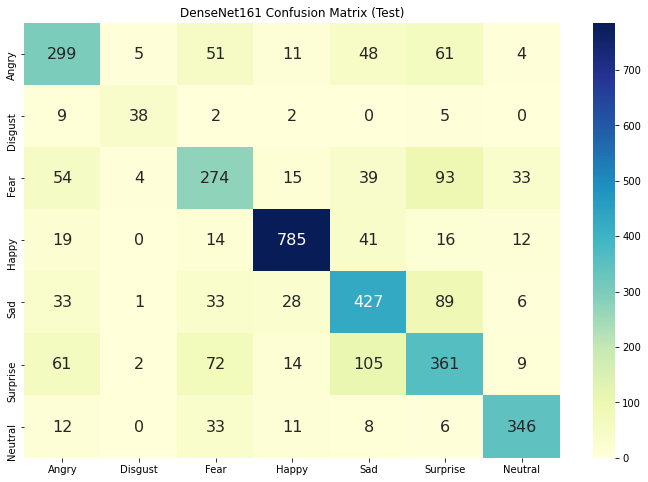

In [23]:
model_name = 'DenseNet161'
densenet161 = models.densenet161()
densenet161.classifier = nn.Linear(2208, num_classes)
if os.path.exists('/content/gdrive/My Drive/{}.model'.format(model_name)):
    print('Found pretrained model!')
    saved_model = torch.load('/content/gdrive/My Drive/{}.model'.format(model_name))
    densenet161.load_state_dict(saved_model['model'])
    model_list[model_name] = densenet161
    train_loss = saved_model['train_losses']
    valid_loss = saved_model['valid_losses']
    test_loss = saved_model['test_losses']
    train_accuracy[model_name] = saved_model['train_accuracy']
    valid_accuracy[model_name] = saved_model['valid_accuracy']
    test_accuracy[model_name] = saved_model['test_accuracy']
densenet161.to(device)
densenet161.eval()
print('{} Test Loss: {}'.format(model_name, test_loss[-1]))
make_plots(train_accuracy[model_name], valid_accuracy[model_name], model_name, 'Accuracy')
make_plots(train_loss, valid_loss, model_name, 'Loss')
loss, acc, matrix = valid(densenet161, dev_loader, criterion, device, 0, 'Validation Dataset', empty_cache)
plot_matrix(matrix, 'Validation', model_name)
loss, acc, matrix = valid(densenet161, test_loader, criterion, device, 0, 'Test Dataset', empty_cache)
plot_matrix(matrix, 'Test', model_name)

Found pretrained model!
DenseNet169 Test Loss: 1.2466045045912415


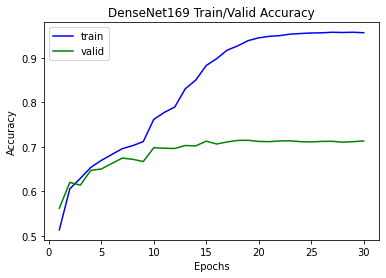

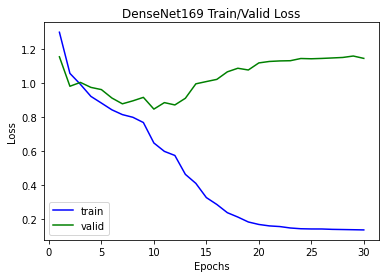

Epoch: 1	Validation Dataset Validation Time: 8.4705


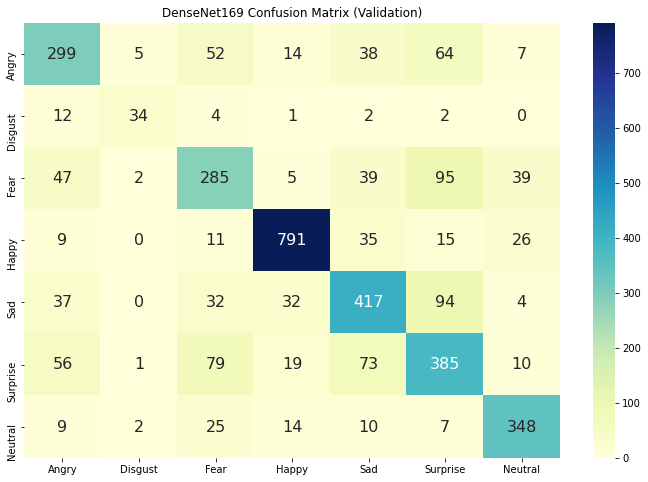

Epoch: 1	Test Dataset Validation Time: 8.4548


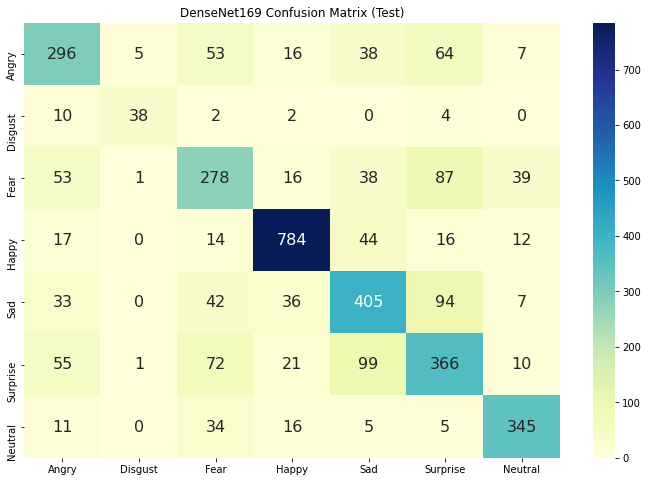

In [24]:
model_name = 'DenseNet169'
densenet169 = models.densenet169()
densenet169.classifier = nn.Linear(1664, num_classes)
if os.path.exists('/content/gdrive/My Drive/{}.model'.format(model_name)):
    print('Found pretrained model!')
    saved_model = torch.load('/content/gdrive/My Drive/{}.model'.format(model_name))
    densenet169.load_state_dict(saved_model['model'])
    model_list[model_name] = densenet169
    train_loss = saved_model['train_losses']
    valid_loss = saved_model['valid_losses']
    test_loss = saved_model['test_losses']
    train_accuracy[model_name] = saved_model['train_accuracy']
    valid_accuracy[model_name] = saved_model['valid_accuracy']
    test_accuracy[model_name] = saved_model['test_accuracy']
densenet169.to(device)
densenet169.eval()
print('{} Test Loss: {}'.format(model_name, test_loss[-1]))
make_plots(train_accuracy[model_name], valid_accuracy[model_name], model_name, 'Accuracy')
make_plots(train_loss, valid_loss, model_name, 'Loss')
loss, acc, matrix = valid(densenet169, dev_loader, criterion, device, 0, 'Validation Dataset', empty_cache)
plot_matrix(matrix, 'Validation', model_name)
loss, acc, matrix = valid(densenet169, test_loader, criterion, device, 0, 'Test Dataset', empty_cache)
plot_matrix(matrix, 'Test', model_name)

Found pretrained model!
DenseNet201 Test Loss: 1.2560433568279912


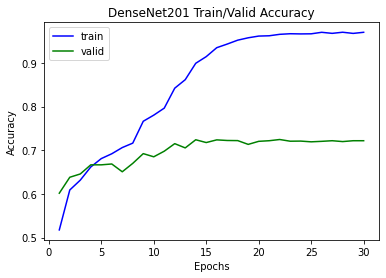

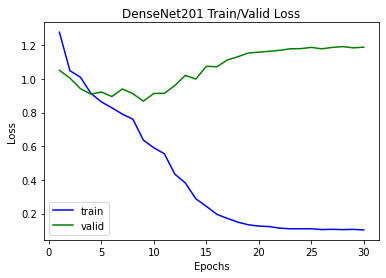

Epoch: 1	Validation Dataset Validation Time: 9.5996


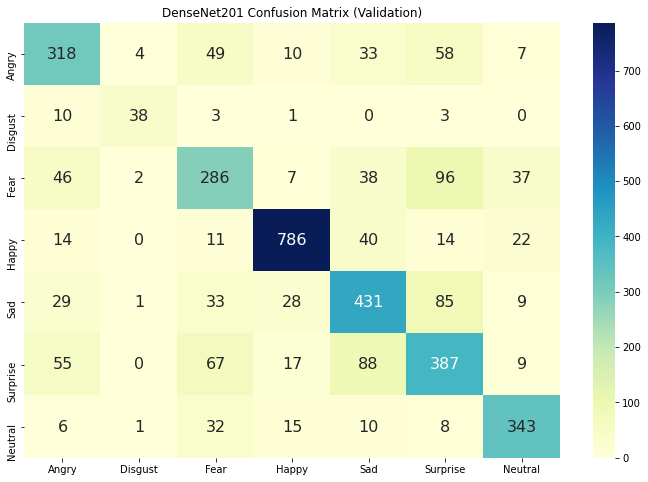

Epoch: 1	Test Dataset Validation Time: 9.7071


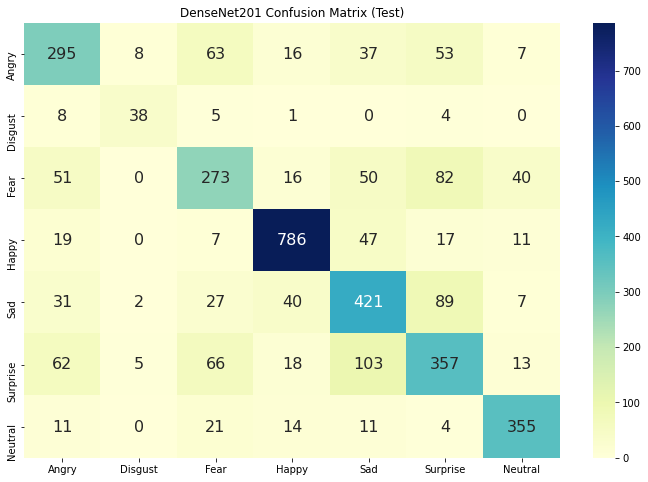

In [25]:
model_name = 'DenseNet201'
densenet201 = models.densenet201()
densenet201.classifier = nn.Linear(1920, num_classes)
if os.path.exists('/content/gdrive/My Drive/{}.model'.format(model_name)):
    print('Found pretrained model!')
    saved_model = torch.load('/content/gdrive/My Drive/{}.model'.format(model_name))
    densenet201.load_state_dict(saved_model['model'])
    model_list[model_name] = densenet201
    train_loss = saved_model['train_losses']
    valid_loss = saved_model['valid_losses']
    test_loss = saved_model['test_losses']
    train_accuracy[model_name] = saved_model['train_accuracy']
    valid_accuracy[model_name] = saved_model['valid_accuracy']
    test_accuracy[model_name] = saved_model['test_accuracy']
densenet201.to(device)
densenet201.eval()
print('{} Test Loss: {}'.format(model_name, test_loss[-1]))
make_plots(train_accuracy[model_name], valid_accuracy[model_name], model_name, 'Accuracy')
make_plots(train_loss, valid_loss, model_name, 'Loss')
loss, acc, matrix = valid(densenet201, dev_loader, criterion, device, 0, 'Validation Dataset', empty_cache)
plot_matrix(matrix, 'Validation', model_name)
loss, acc, matrix = valid(densenet201, test_loader, criterion, device, 0, 'Test Dataset', empty_cache)
plot_matrix(matrix, 'Test', model_name)

Found pretrained model!
VGG11 Test Loss: 1.2049305546220648


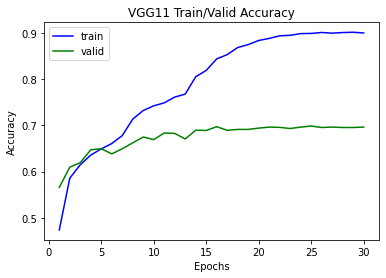

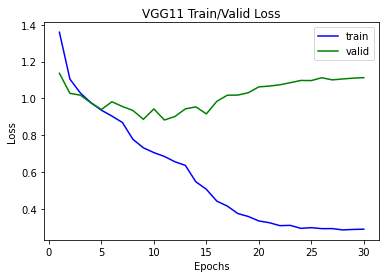

Epoch: 1	Validation Dataset Validation Time: 7.3674


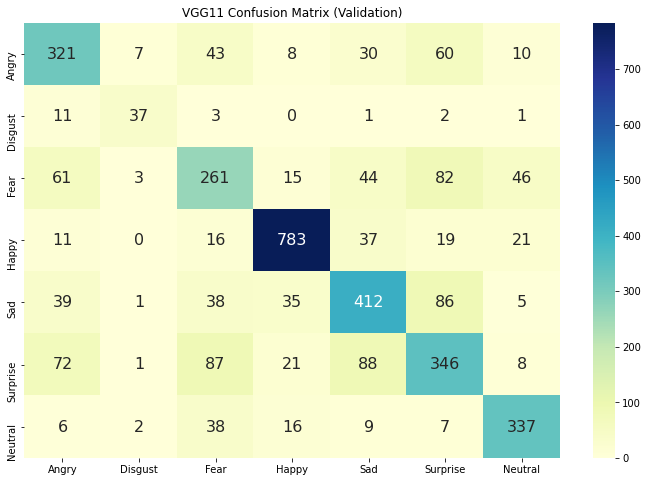

Epoch: 1	Test Dataset Validation Time: 7.2129


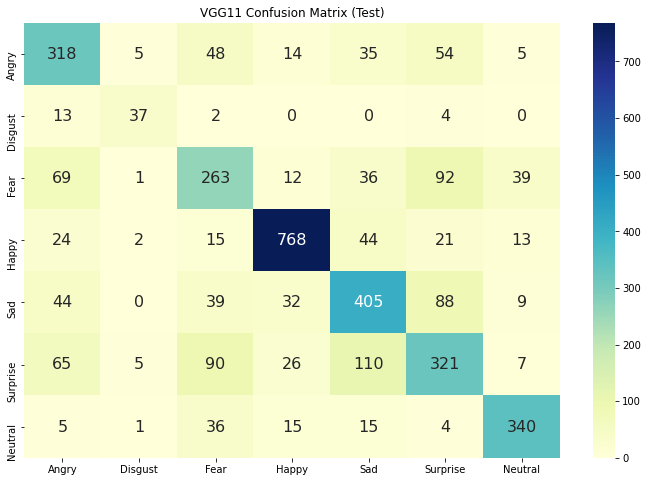

In [26]:
model_name = 'VGG11'
vgg11 = models.vgg11_bn()
vgg11.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(4096, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(4096, num_classes)
)
if os.path.exists('/content/gdrive/My Drive/{}.model'.format(model_name)):
    print('Found pretrained model!')
    saved_model = torch.load('/content/gdrive/My Drive/{}.model'.format(model_name))
    vgg11.load_state_dict(saved_model['model'])
    model_list[model_name] = vgg11
    train_loss = saved_model['train_losses']
    valid_loss = saved_model['valid_losses']
    test_loss = saved_model['test_losses']
    train_accuracy[model_name] = saved_model['train_accuracy']
    valid_accuracy[model_name] = saved_model['valid_accuracy']
    test_accuracy[model_name] = saved_model['test_accuracy']
vgg11.to(device)
vgg11.eval()
print('{} Test Loss: {}'.format(model_name, test_loss[-1]))
make_plots(train_accuracy[model_name], valid_accuracy[model_name], model_name, 'Accuracy')
make_plots(train_loss, valid_loss, model_name, 'Loss')
loss, acc, matrix = valid(vgg11, dev_loader, criterion, device, 0, 'Validation Dataset', empty_cache)
plot_matrix(matrix, 'Validation', model_name)
loss, acc, matrix = valid(vgg11, test_loader, criterion, device, 0, 'Test Dataset', empty_cache)
plot_matrix(matrix, 'Test', model_name)

Found pretrained model!
VGG13 Test Loss: 1.1659252202235302


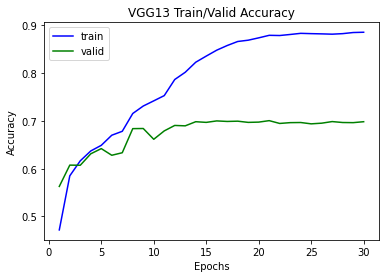

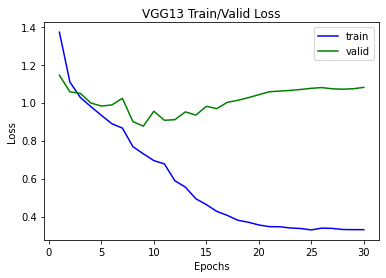

Epoch: 1	Validation Dataset Validation Time: 10.8648


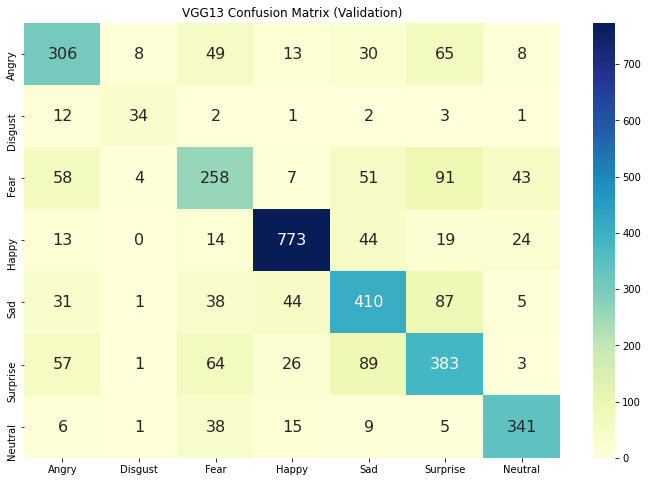

Epoch: 1	Test Dataset Validation Time: 10.3984


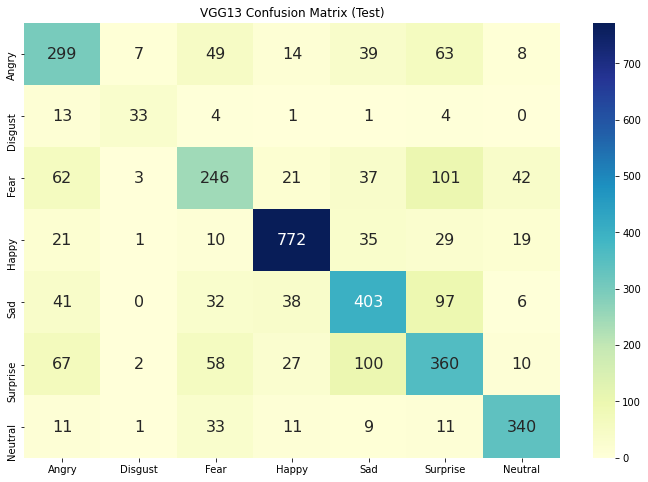

In [27]:
model_name = 'VGG13'
vgg13 = models.vgg13_bn()
vgg13.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(4096, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(4096, num_classes)
)
if os.path.exists('/content/gdrive/My Drive/{}.model'.format(model_name)):
    print('Found pretrained model!')
    saved_model = torch.load('/content/gdrive/My Drive/{}.model'.format(model_name))
    vgg13.load_state_dict(saved_model['model'])
    model_list[model_name] = vgg13
    train_loss = saved_model['train_losses']
    valid_loss = saved_model['valid_losses']
    test_loss = saved_model['test_losses']
    train_accuracy[model_name] = saved_model['train_accuracy']
    valid_accuracy[model_name] = saved_model['valid_accuracy']
    test_accuracy[model_name] = saved_model['test_accuracy']
vgg13.to(device)
vgg13.eval()
print('{} Test Loss: {}'.format(model_name, test_loss[-1]))
make_plots(train_accuracy[model_name], valid_accuracy[model_name], model_name, 'Accuracy')
make_plots(train_loss, valid_loss, model_name, 'Loss')
loss, acc, matrix = valid(vgg13, dev_loader, criterion, device, 0, 'Validation Dataset', empty_cache)
plot_matrix(matrix, 'Validation', model_name)
loss, acc, matrix = valid(vgg13, test_loader, criterion, device, 0, 'Test Dataset', empty_cache)
plot_matrix(matrix, 'Test', model_name)

Found pretrained model!
VGG16 Test Loss: 1.1915243237140085


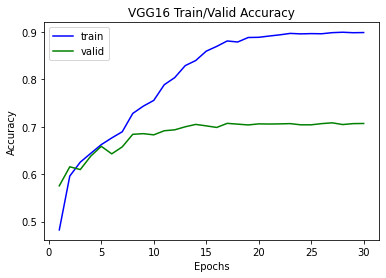

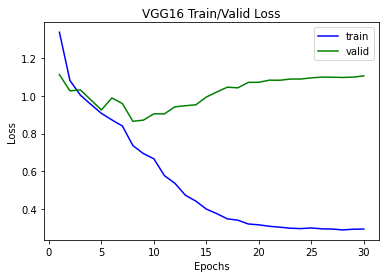

Epoch: 1	Validation Dataset Validation Time: 10.8400


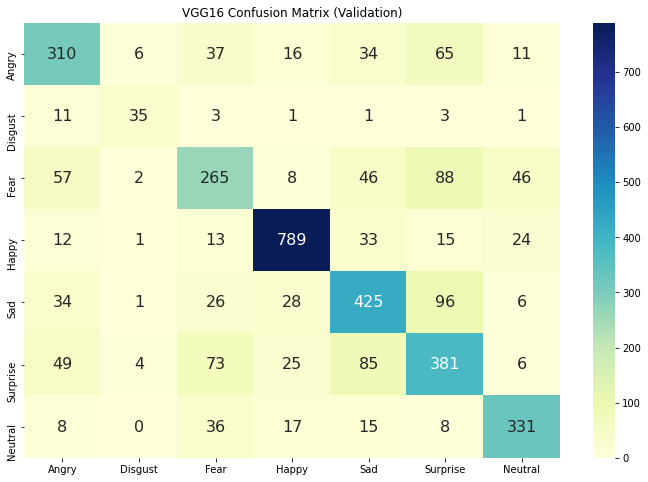

Epoch: 1	Test Dataset Validation Time: 10.5154


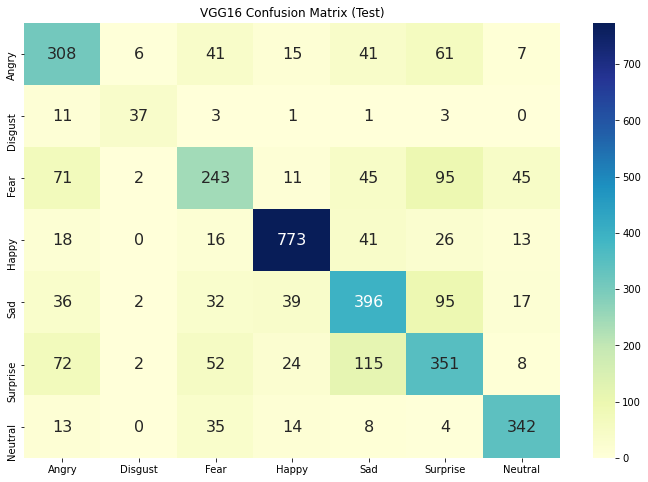

In [28]:
model_name = 'VGG16'
vgg16 = models.vgg16_bn()
vgg16.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(4096, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(4096, num_classes)
)
if os.path.exists('/content/gdrive/My Drive/{}.model'.format(model_name)):
    print('Found pretrained model!')
    saved_model = torch.load('/content/gdrive/My Drive/{}.model'.format(model_name))
    vgg16.load_state_dict(saved_model['model'])
    model_list[model_name] = vgg16
    train_loss = saved_model['train_losses']
    valid_loss = saved_model['valid_losses']
    test_loss = saved_model['test_losses']
    train_accuracy[model_name] = saved_model['train_accuracy']
    valid_accuracy[model_name] = saved_model['valid_accuracy']
    test_accuracy[model_name] = saved_model['test_accuracy']
vgg16.to(device)
vgg16.eval()
print('{} Test Loss: {}'.format(model_name, test_loss[-1]))
make_plots(train_accuracy[model_name], valid_accuracy[model_name], model_name, 'Accuracy')
make_plots(train_loss, valid_loss, model_name, 'Loss')
loss, acc, matrix = valid(vgg16, dev_loader, criterion, device, 0, 'Validation Dataset', empty_cache)
plot_matrix(matrix, 'Validation', model_name)
loss, acc, matrix = valid(vgg16, test_loader, criterion, device, 0, 'Test Dataset', empty_cache)
plot_matrix(matrix, 'Test', model_name)

Found pretrained model!
VGG19 Test Loss: 1.331185768404833


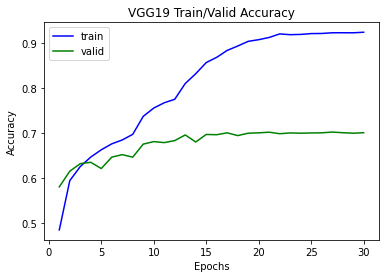

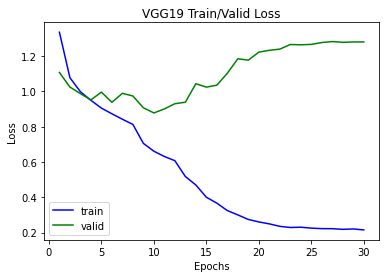

Epoch: 1	Validation Dataset Validation Time: 13.6933


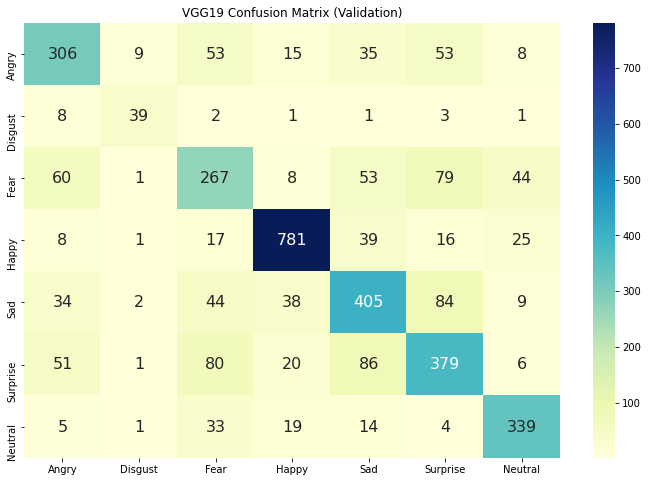

Epoch: 1	Test Dataset Validation Time: 13.5936


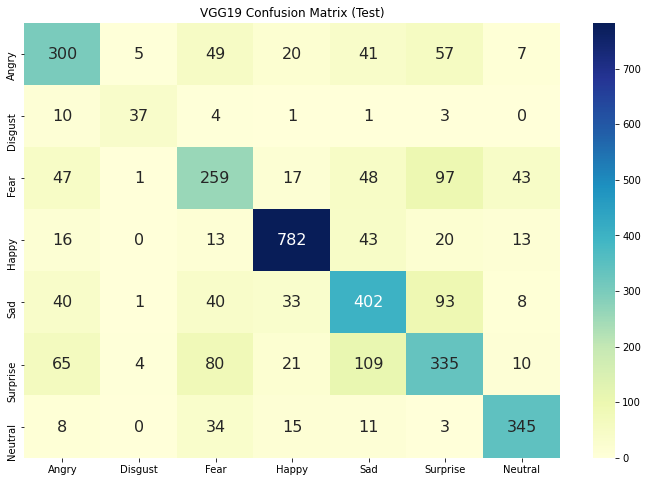

In [29]:
model_name = 'VGG19'
vgg19 = models.vgg19_bn()
vgg19.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(4096, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(4096, num_classes)
)
if os.path.exists('/content/gdrive/My Drive/{}.model'.format(model_name)):
    print('Found pretrained model!')
    saved_model = torch.load('/content/gdrive/My Drive/{}.model'.format(model_name))
    vgg19.load_state_dict(saved_model['model'])
    model_list[model_name] = vgg19
    train_loss = saved_model['train_losses']
    valid_loss = saved_model['valid_losses']
    test_loss = saved_model['test_losses']
    train_accuracy[model_name] = saved_model['train_accuracy']
    valid_accuracy[model_name] = saved_model['valid_accuracy']
    test_accuracy[model_name] = saved_model['test_accuracy']
vgg19.to(device)
vgg19.eval()
print('{} Test Loss: {}'.format(model_name, test_loss[-1]))
make_plots(train_accuracy[model_name], valid_accuracy[model_name], model_name, 'Accuracy')
make_plots(train_loss, valid_loss, model_name, 'Loss')
loss, acc, matrix = valid(vgg19, dev_loader, criterion, device, 0, 'Validation Dataset', empty_cache)
plot_matrix(matrix, 'Validation', model_name)
loss, acc, matrix = valid(vgg19, test_loader, criterion, device, 0, 'Test Dataset', empty_cache)
plot_matrix(matrix, 'Test', model_name)

In [30]:
test_df = pd.DataFrame(test_accuracy, index=range(1, 31))
test_df.to_csv('/content/gdrive/My Drive/model_accuracy.csv')

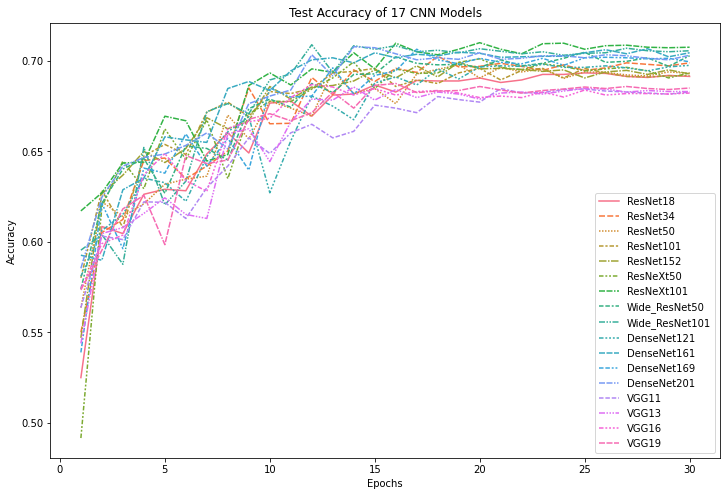

In [31]:
plt.figure(figsize=(12,8))
ax = sns.lineplot(data=test_df)
ax.set(xlabel='Epochs', ylabel='Accuracy', title="Test Accuracy of 17 CNN Models")
plt.savefig('/content/gdrive/My Drive/model_accuracy.png')
plt.show()

In [32]:
test_dict = dict(test_df.loc[30])
sorted_models = [i[0] for i in sorted(test_dict.items(), key=lambda k:k[1], reverse=True)]

# Ensemble Functions

In [33]:
def valid_average_ensemble(model_list, model_weights, val_loader, criterion, device, dataset, empty_cache=False):
    start = time.time()
    test_loss = []
    accuracy = 0
    total = 0
    true_label = []
    pred_label = []

    with torch.no_grad():
        for batch_num, (feats, labels) in enumerate(val_loader):
            feats, labels = feats.to(device), labels.to(device)
            output_list = []
            for name, model in model_list.items():
                model.eval()
                outputs = model(feats.float())
                output_list.append(outputs * model_weights[name])
            output_list = torch.stack(output_list)
            output_list = torch.mean(output_list, dim=0)
            
            pred_labels = torch.max(F.softmax(output_list, dim=1), 1)[1]
            pred_labels = pred_labels.view(-1)
            
            loss = criterion(output_list, labels.long())
            
            accuracy += torch.sum(torch.eq(pred_labels, labels)).item()
            total += len(labels)
            test_loss.extend([loss.item()]*feats.size()[0])

            pred_label.extend(pred_labels.detach().cpu().numpy())
            true_label.extend(labels.detach().cpu().numpy())

            if empty_cache:
                torch.cuda.empty_cache()
                del feats
                del labels
                del loss
    
    matrix = confusion_matrix(true_label, pred_label)
    end = time.time()
    print('{} Validation Time: {:.4f}'.format(dataset, end-start))
    return np.mean(test_loss), accuracy/total, matrix

In [34]:
def valid_mode_ensemble(model_list, val_loader, criterion, device, dataset, empty_cache=False):
    start = time.time()
    test_loss = []
    accuracy = 0
    total = 0
    true_label = []
    pred_label = []

    with torch.no_grad():
        for batch_num, (feats, labels) in enumerate(val_loader):
            feats, labels = feats.to(device), labels.to(device)
            pred_list = []
            avg_loss = []
            for name, model in model_list.items():
                model.eval()
                outputs = model(feats.float())
                loss = criterion(outputs, labels.long())
                avg_loss.append(loss.item())
                pred_labels = torch.max(F.softmax(outputs, dim=1), 1)[1]
                pred_labels = pred_labels.view(-1)
                pred_list.append(pred_labels)
            
            avg_loss = np.mean(avg_loss)

            pred_list = torch.stack(pred_list)
            pred_list = torch.mode(pred_list, dim=0)[0]

            pred_label.extend(pred_list.detach().cpu().numpy())
            true_label.extend(labels.detach().cpu().numpy())
            
            accuracy += torch.sum(torch.eq(pred_list, labels)).item()
            total += len(labels)
            test_loss.extend([avg_loss]*feats.size()[0])

            if empty_cache:
                torch.cuda.empty_cache()
                del feats
                del labels
                del loss
    
    
    matrix = confusion_matrix(true_label, pred_label)
    end = time.time()
    print('{} Validation Time: {:.4f}'.format(dataset, end-start))
    return np.mean(test_loss), accuracy/total, matrix

# Ensemble Experiments

In [37]:
def plot_ensembles(a, b):
    plt.figure(1)
    plt.plot(range(1, len(a) + 1), a, 'b', label='valid')
    plt.plot(range(1, len(b) + 1), b, 'g', label='test')
    plt.title('Ensemble Model Validation/Test Accuracy')
    plt.xlabel('Number of Models')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('/content/gdrive/My Drive/ensemble_accuracy.png')
    plt.show()

Evaluating Top 1 Model Ensemble
Selected Models: ['ResNeXt101']
Train Dataset Validation Time: 110.1079
Train Loss: 0.03852	Train Accuracy: 0.98819


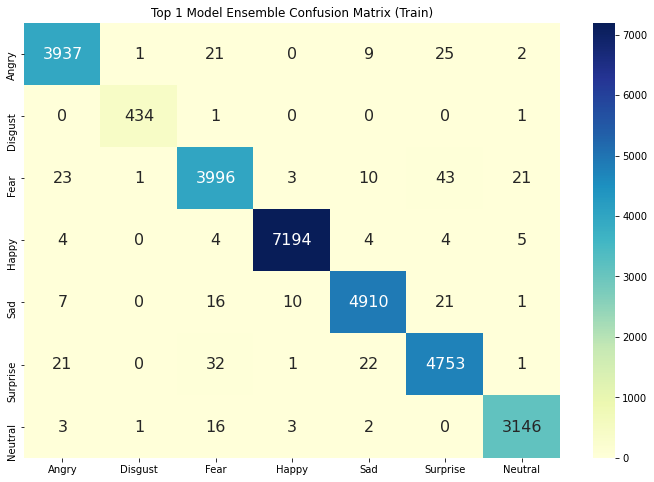

Validation Dataset Validation Time: 15.8413
Validation Loss: 1.57107	Validation Accuracy: 0.72010


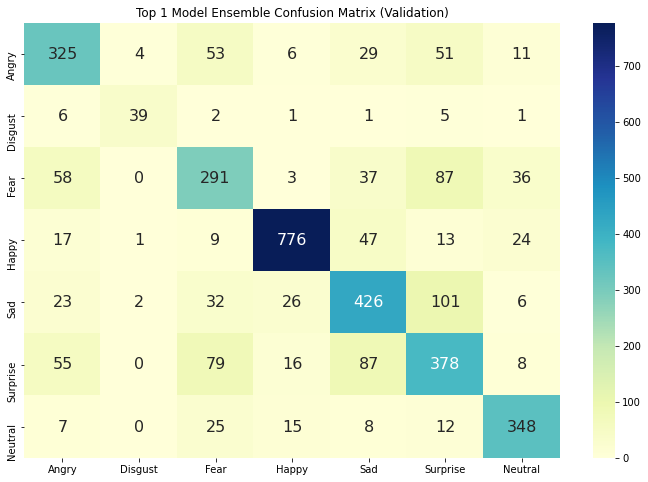

Test Dataset Validation Time: 15.6866
Test Loss: 1.71400	Test Accuracy: 0.70760


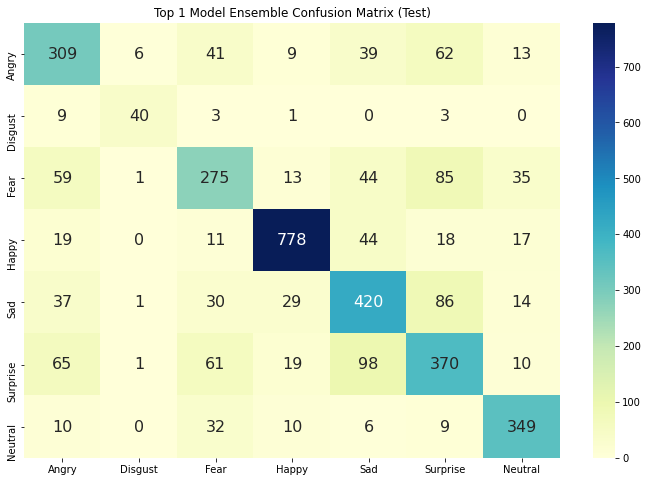

Evaluating Top 2 Model Ensemble
Selected Models: ['ResNeXt101', 'Wide_ResNet101']
Train Dataset Validation Time: 188.7700
Train Loss: 0.05887	Train Accuracy: 0.98206


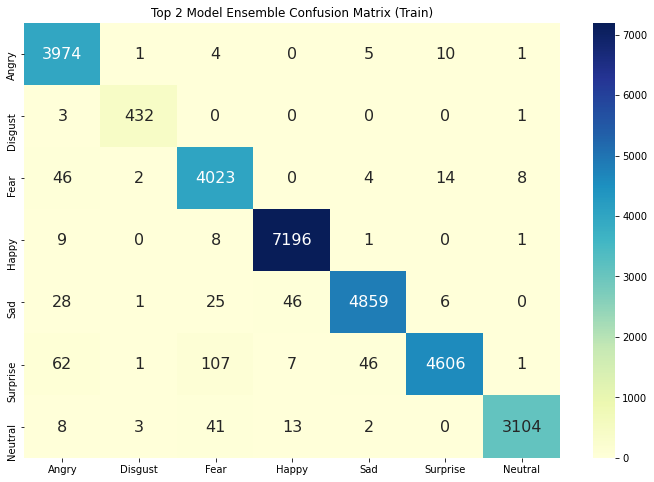

Validation Dataset Validation Time: 25.6182
Validation Loss: 1.40431	Validation Accuracy: 0.71146


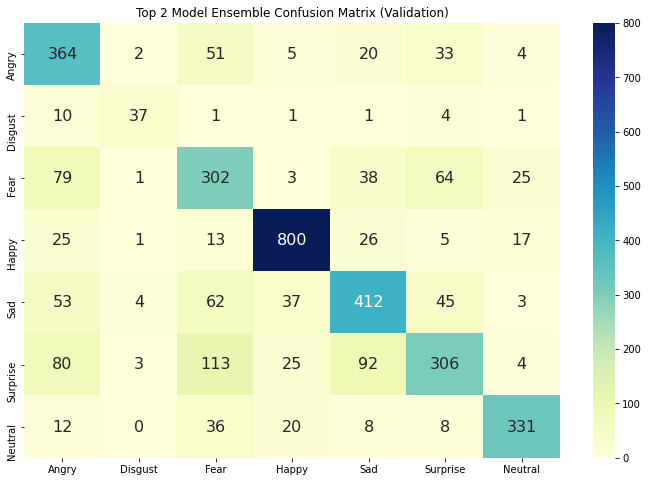

Test Dataset Validation Time: 25.5183
Test Loss: 1.50431	Test Accuracy: 0.70343


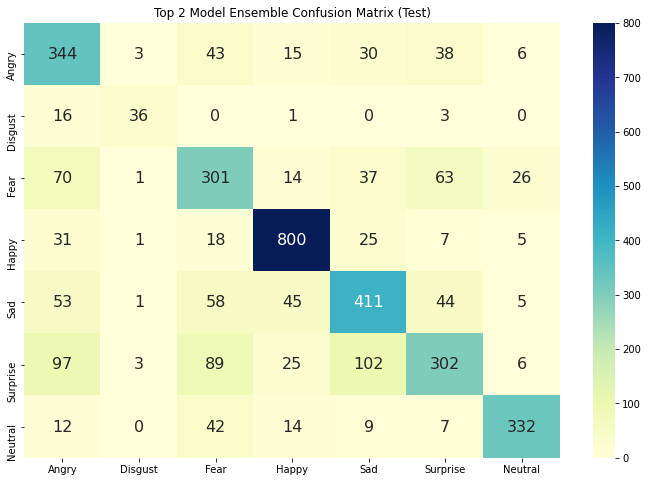

Evaluating Top 3 Model Ensemble
Selected Models: ['ResNeXt101', 'Wide_ResNet101', 'DenseNet161']
Train Dataset Validation Time: 249.0467
Train Loss: 0.06567	Train Accuracy: 0.99091


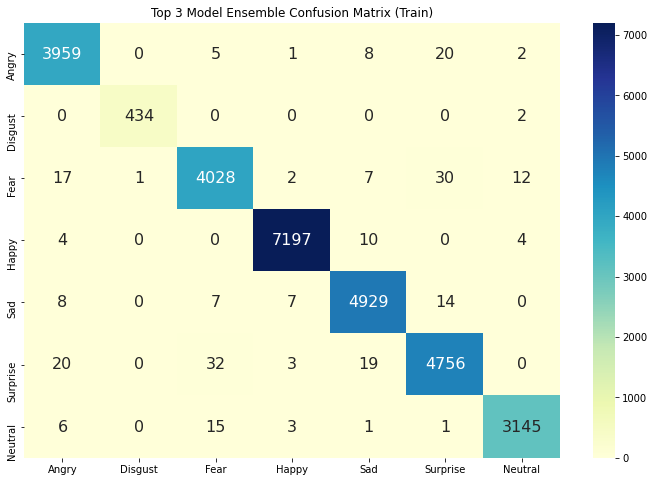

Validation Dataset Validation Time: 33.3019
Validation Loss: 1.32428	Validation Accuracy: 0.73822


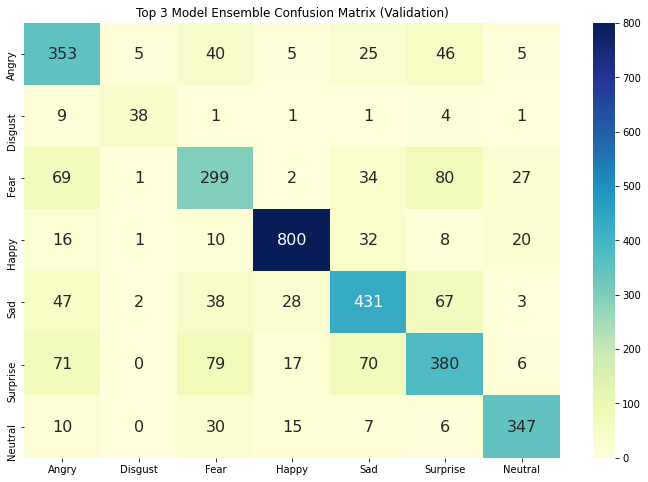

Test Dataset Validation Time: 33.0804
Test Loss: 1.42978	Test Accuracy: 0.71624


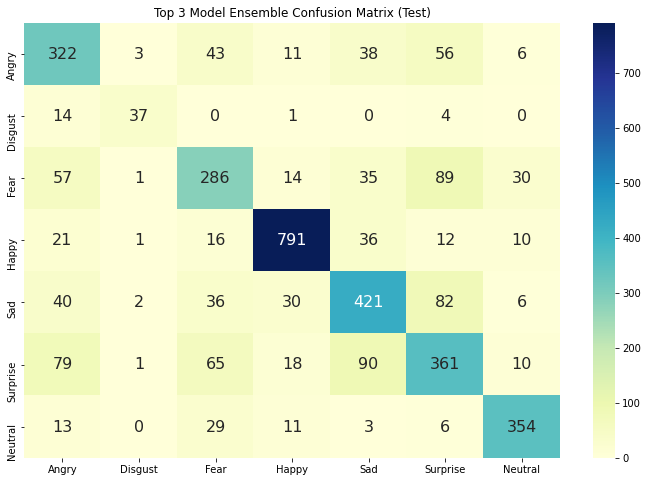

Evaluating Top 4 Model Ensemble
Selected Models: ['ResNeXt101', 'Wide_ResNet101', 'DenseNet161', 'DenseNet201']
Train Dataset Validation Time: 292.7447
Train Loss: 0.07005	Train Accuracy: 0.99129


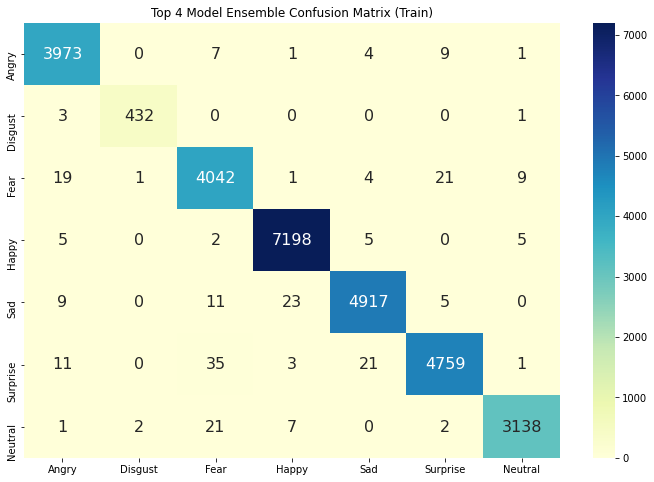

Validation Dataset Validation Time: 38.6994
Validation Loss: 1.29027	Validation Accuracy: 0.73822


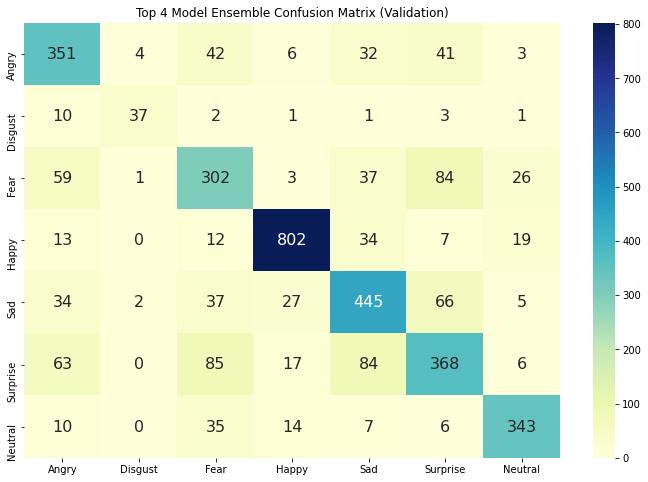

Test Dataset Validation Time: 38.5158
Test Loss: 1.38635	Test Accuracy: 0.72598


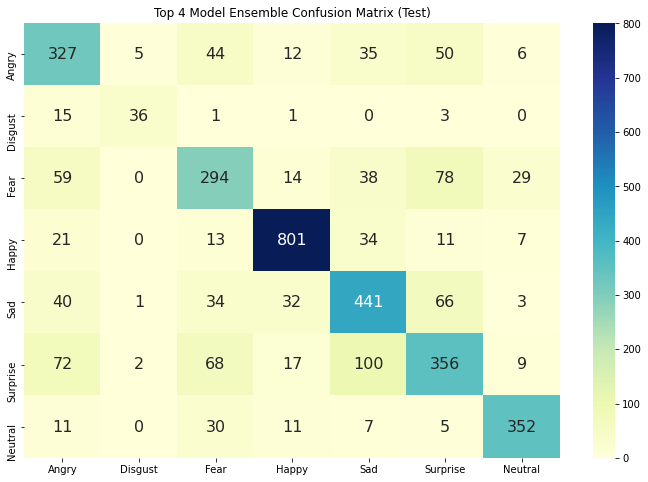

Evaluating Top 5 Model Ensemble
Selected Models: ['ResNeXt101', 'Wide_ResNet101', 'DenseNet161', 'DenseNet201', 'Wide_ResNet50']
Train Dataset Validation Time: 337.5592
Train Loss: 0.07198	Train Accuracy: 0.99213


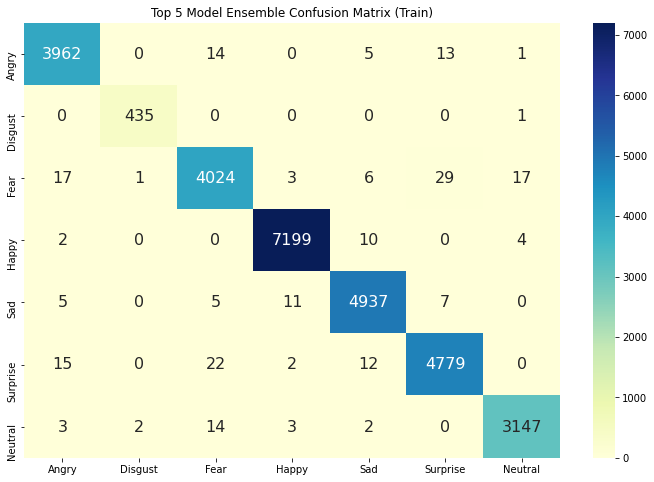

Validation Dataset Validation Time: 43.9560
Validation Loss: 1.28371	Validation Accuracy: 0.73850


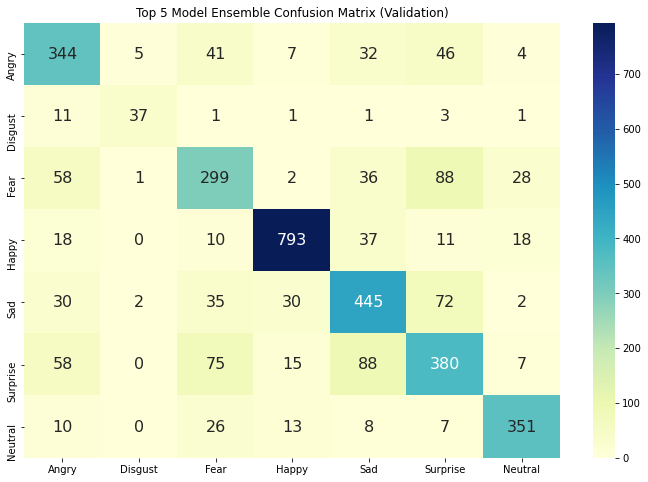

Test Dataset Validation Time: 44.4167
Test Loss: 1.37675	Test Accuracy: 0.73266


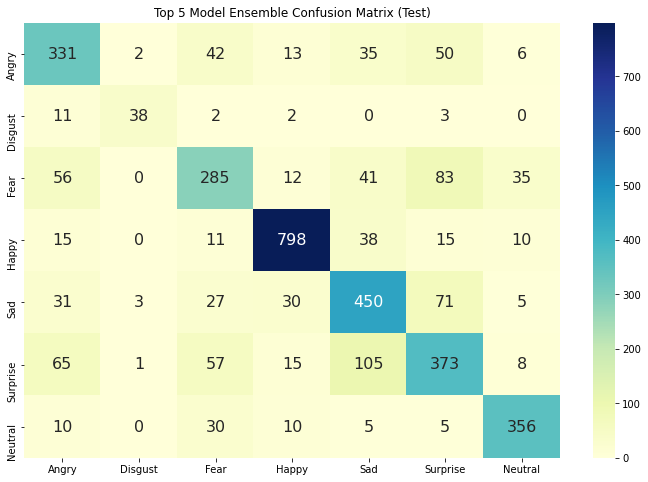

Evaluating Top 6 Model Ensemble
Selected Models: ['ResNeXt101', 'Wide_ResNet101', 'DenseNet161', 'DenseNet201', 'Wide_ResNet50', 'DenseNet169']
Train Dataset Validation Time: 369.8238
Train Loss: 0.07941	Train Accuracy: 0.99133


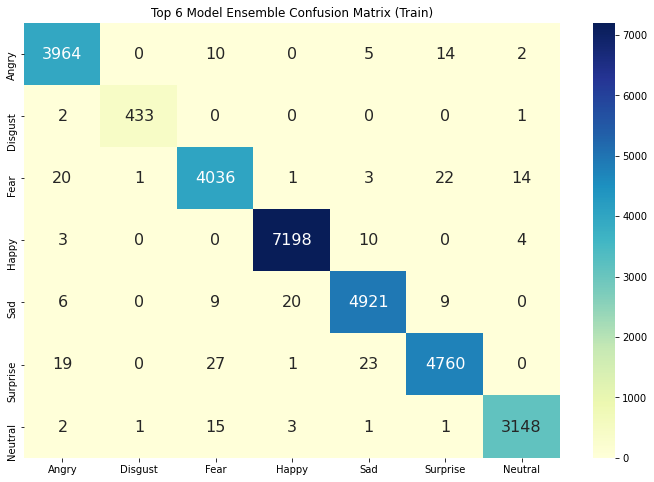

Validation Dataset Validation Time: 48.1071
Validation Loss: 1.26067	Validation Accuracy: 0.73962


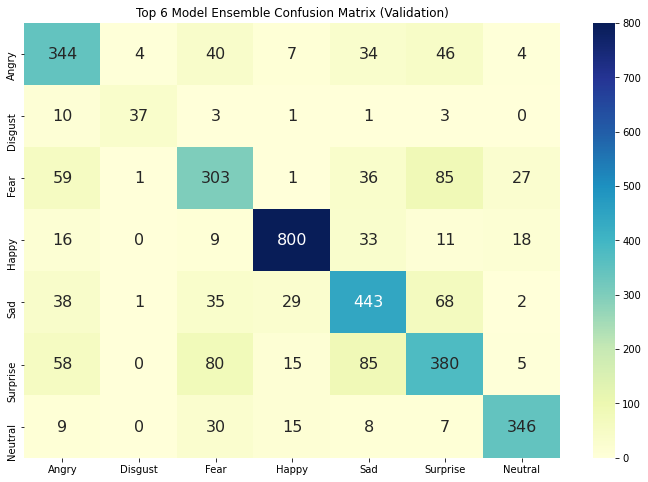

Test Dataset Validation Time: 48.3871
Test Loss: 1.35506	Test Accuracy: 0.73239


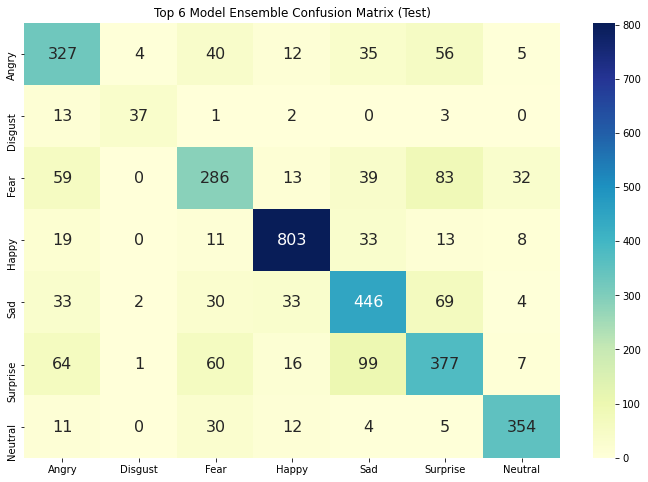

Evaluating Top 7 Model Ensemble
Selected Models: ['ResNeXt101', 'Wide_ResNet101', 'DenseNet161', 'DenseNet201', 'Wide_ResNet50', 'DenseNet169', 'ResNet34']
Train Dataset Validation Time: 381.4042
Train Loss: 0.10132	Train Accuracy: 0.99014


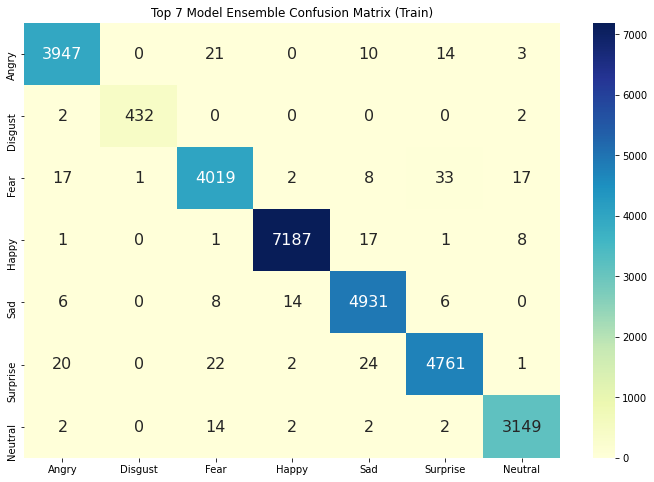

Validation Dataset Validation Time: 49.7365
Validation Loss: 1.24793	Validation Accuracy: 0.74157


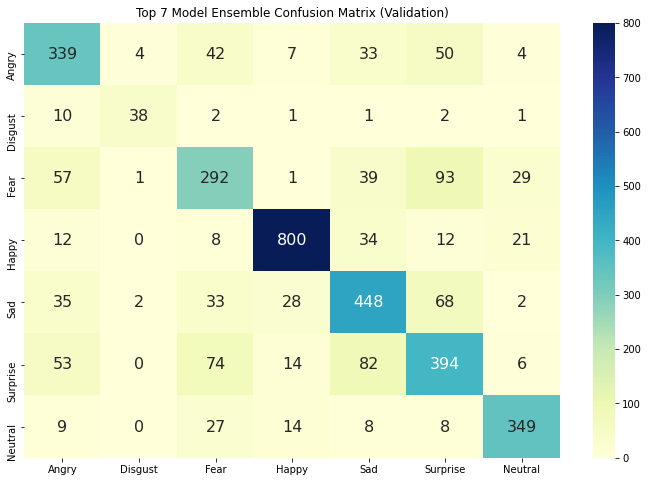

Test Dataset Validation Time: 49.8008
Test Loss: 1.33745	Test Accuracy: 0.73461


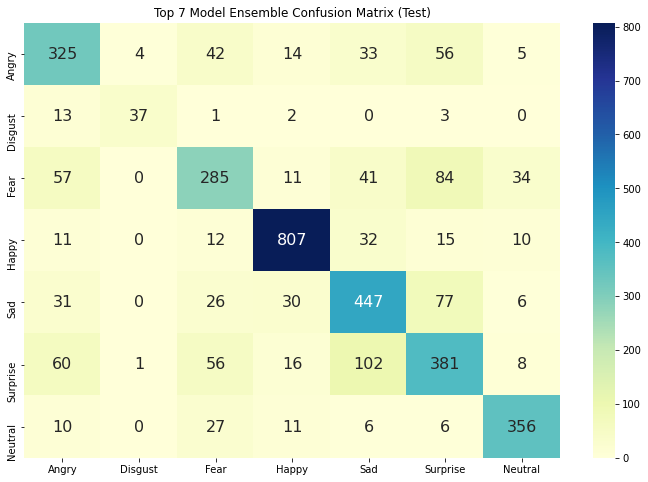

Evaluating Top 8 Model Ensemble
Selected Models: ['ResNeXt101', 'Wide_ResNet101', 'DenseNet161', 'DenseNet201', 'Wide_ResNet50', 'DenseNet169', 'ResNet34', 'DenseNet121']
Train Dataset Validation Time: 408.1127
Train Loss: 0.10217	Train Accuracy: 0.98945


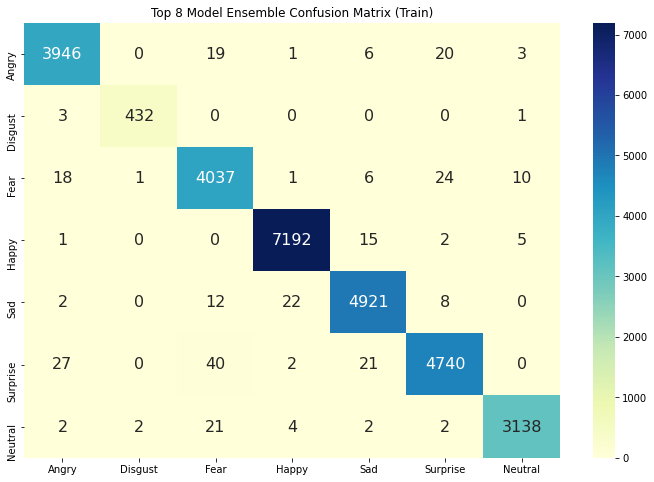

Validation Dataset Validation Time: 53.9669
Validation Loss: 1.23936	Validation Accuracy: 0.73934


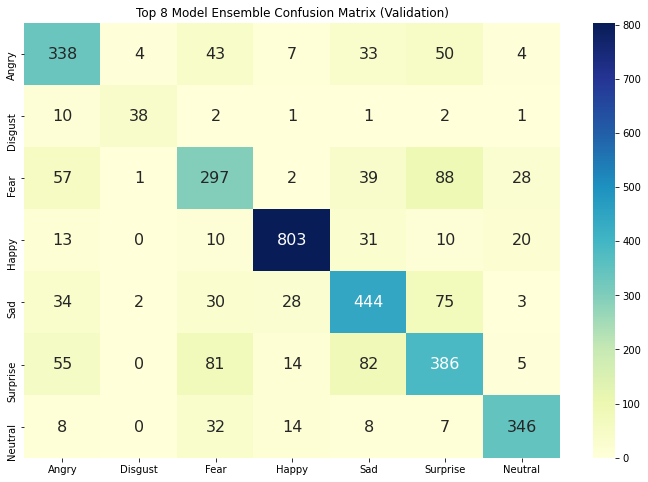

Test Dataset Validation Time: 53.0126
Test Loss: 1.32676	Test Accuracy: 0.73406


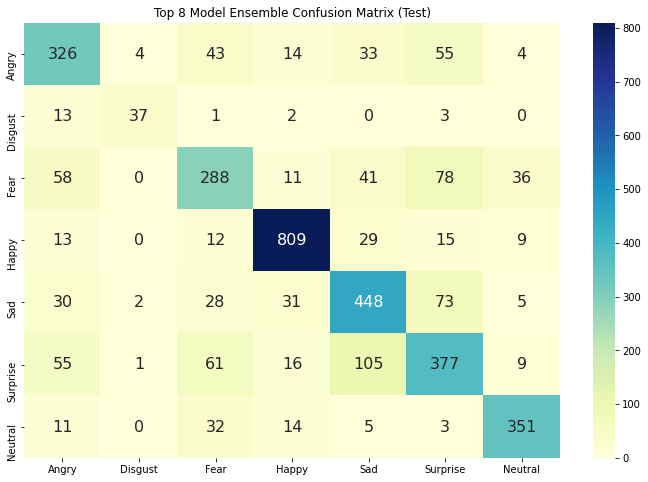

Evaluating Top 9 Model Ensemble
Selected Models: ['ResNeXt101', 'Wide_ResNet101', 'DenseNet161', 'DenseNet201', 'Wide_ResNet50', 'DenseNet169', 'ResNet34', 'DenseNet121', 'ResNeXt50']
Train Dataset Validation Time: 441.2775
Train Loss: 0.09849	Train Accuracy: 0.99070


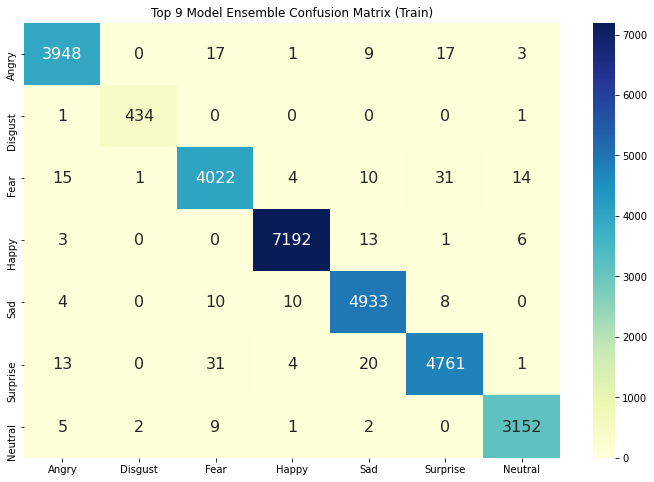

Validation Dataset Validation Time: 57.5084
Validation Loss: 1.24989	Validation Accuracy: 0.74435


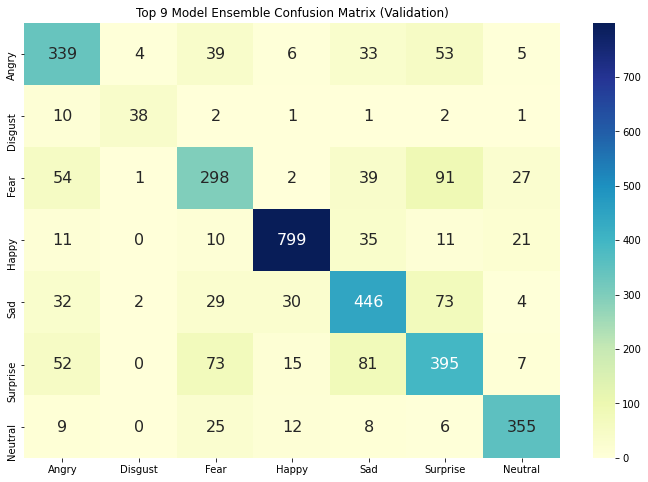

Test Dataset Validation Time: 57.2949
Test Loss: 1.34492	Test Accuracy: 0.73294


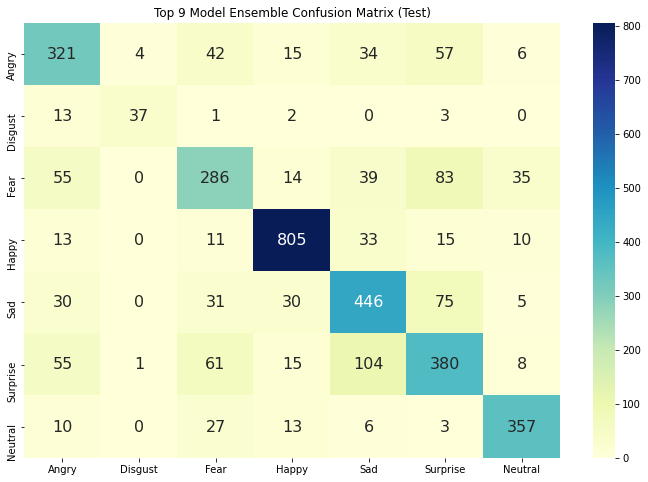

Evaluating Top 10 Model Ensemble
Selected Models: ['ResNeXt101', 'Wide_ResNet101', 'DenseNet161', 'DenseNet201', 'Wide_ResNet50', 'DenseNet169', 'ResNet34', 'DenseNet121', 'ResNeXt50', 'ResNet50']
Train Dataset Validation Time: 465.7764
Train Loss: 0.10450	Train Accuracy: 0.99056


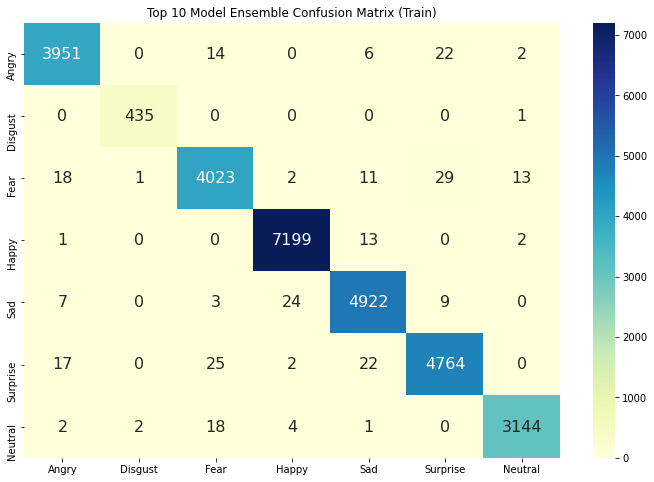

Validation Dataset Validation Time: 60.1918
Validation Loss: 1.24517	Validation Accuracy: 0.74714


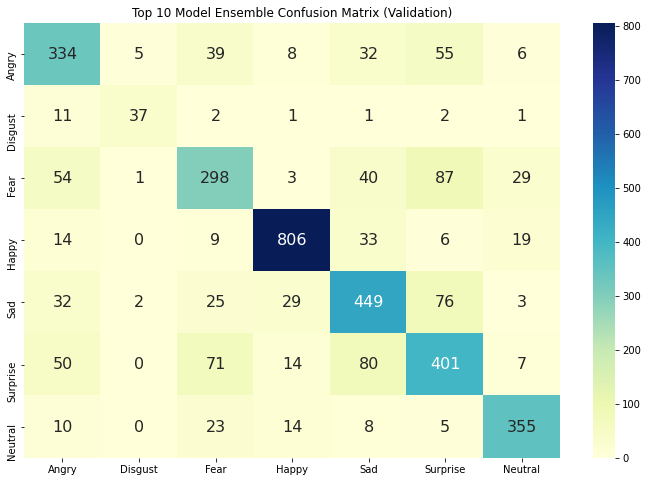

Test Dataset Validation Time: 60.5630
Test Loss: 1.34090	Test Accuracy: 0.73517


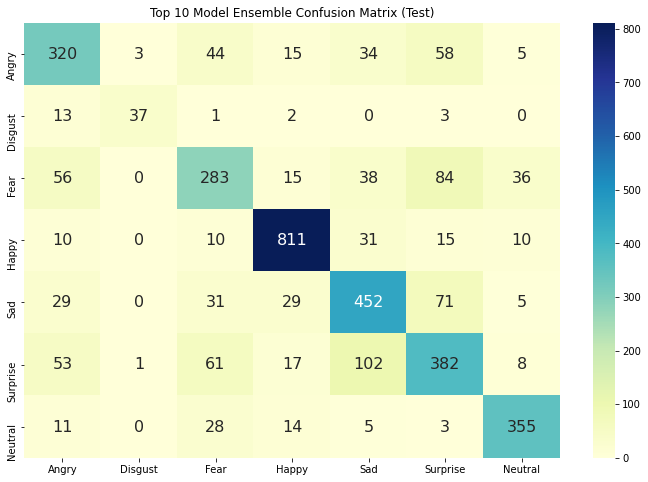

Evaluating Top 11 Model Ensemble
Selected Models: ['ResNeXt101', 'Wide_ResNet101', 'DenseNet161', 'DenseNet201', 'Wide_ResNet50', 'DenseNet169', 'ResNet34', 'DenseNet121', 'ResNeXt50', 'ResNet50', 'ResNet152']
Train Dataset Validation Time: 525.0715
Train Loss: 0.10397	Train Accuracy: 0.99007


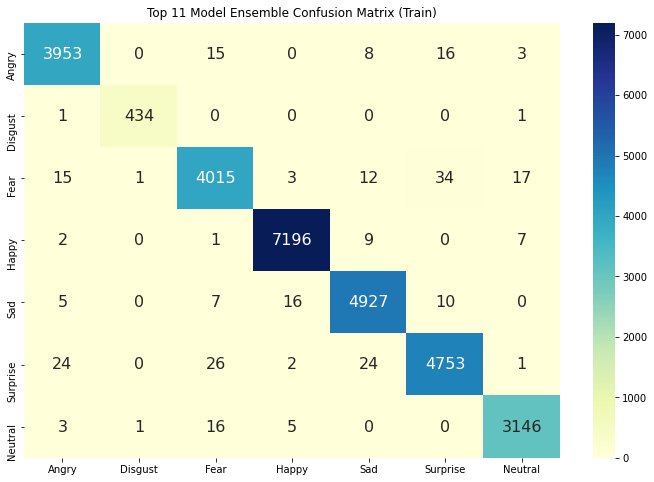

Validation Dataset Validation Time: 68.3061
Validation Loss: 1.25740	Validation Accuracy: 0.75105


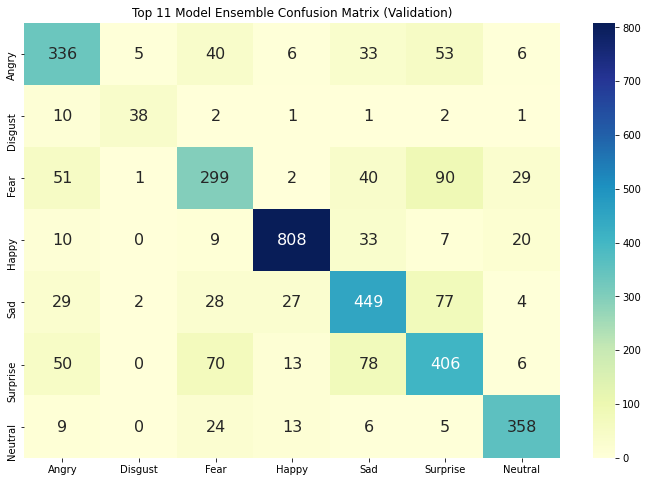

Test Dataset Validation Time: 67.5807
Test Loss: 1.35607	Test Accuracy: 0.73406


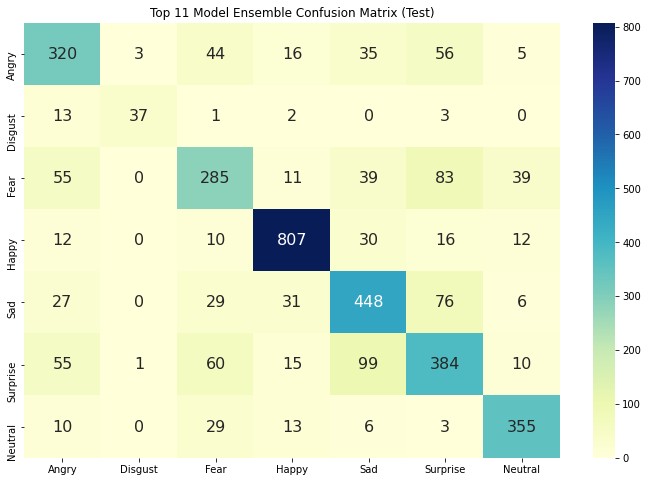

Evaluating Top 12 Model Ensemble
Selected Models: ['ResNeXt101', 'Wide_ResNet101', 'DenseNet161', 'DenseNet201', 'Wide_ResNet50', 'DenseNet169', 'ResNet34', 'DenseNet121', 'ResNeXt50', 'ResNet50', 'ResNet152', 'ResNet101']
Train Dataset Validation Time: 567.1761
Train Loss: 0.10903	Train Accuracy: 0.99007


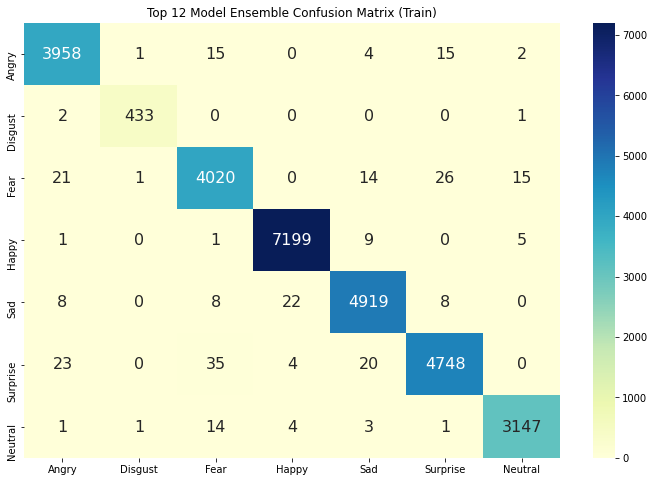

Validation Dataset Validation Time: 73.2819
Validation Loss: 1.26005	Validation Accuracy: 0.75105


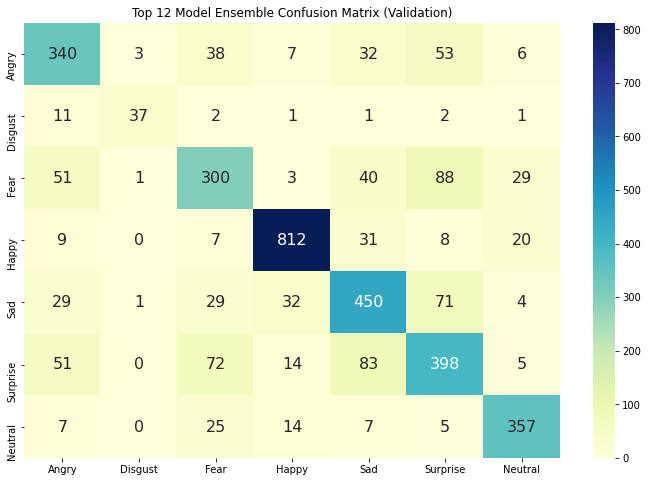

Test Dataset Validation Time: 73.2032
Test Loss: 1.35274	Test Accuracy: 0.73796


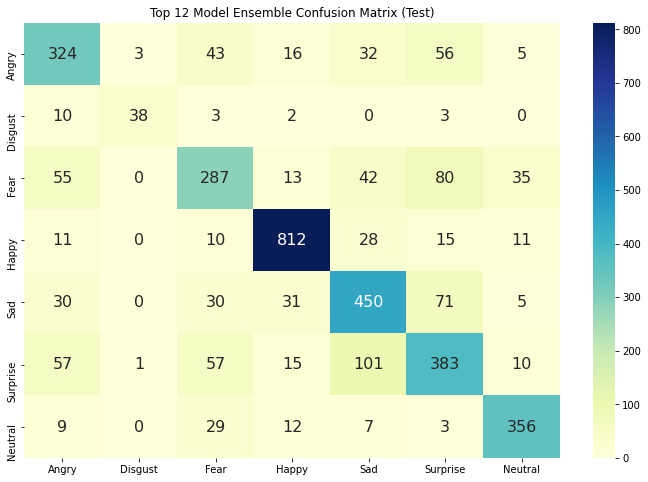

Evaluating Top 13 Model Ensemble
Selected Models: ['ResNeXt101', 'Wide_ResNet101', 'DenseNet161', 'DenseNet201', 'Wide_ResNet50', 'DenseNet169', 'ResNet34', 'DenseNet121', 'ResNeXt50', 'ResNet50', 'ResNet152', 'ResNet101', 'ResNet18']
Train Dataset Validation Time: 574.7676
Train Loss: 0.12669	Train Accuracy: 0.98854


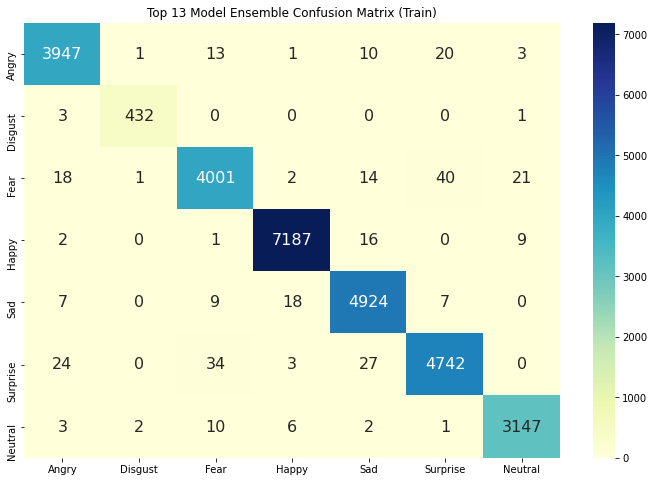

Validation Dataset Validation Time: 74.0153
Validation Loss: 1.24447	Validation Accuracy: 0.75160


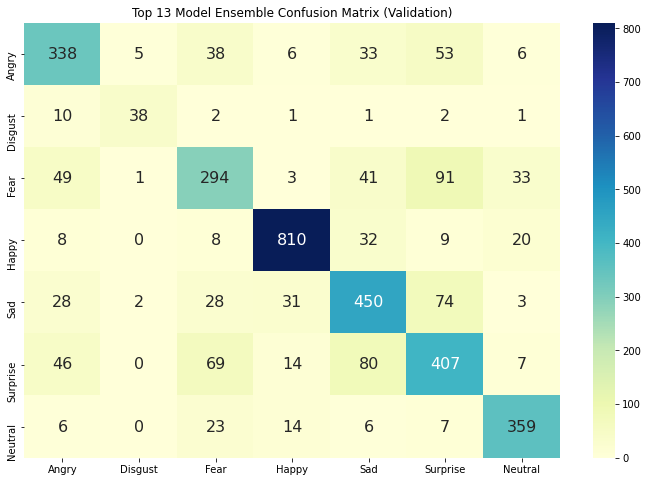

Test Dataset Validation Time: 74.7075
Test Loss: 1.33036	Test Accuracy: 0.74018


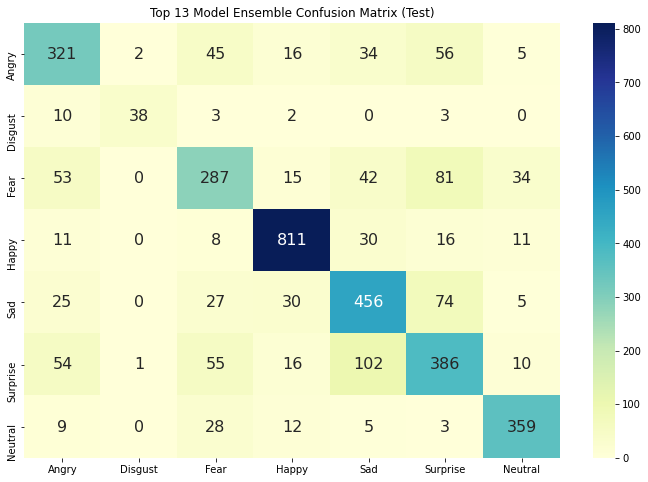

Evaluating Top 14 Model Ensemble
Selected Models: ['ResNeXt101', 'Wide_ResNet101', 'DenseNet161', 'DenseNet201', 'Wide_ResNet50', 'DenseNet169', 'ResNet34', 'DenseNet121', 'ResNeXt50', 'ResNet50', 'ResNet152', 'ResNet101', 'ResNet18', 'VGG19']
Train Dataset Validation Time: 629.3546
Train Loss: 0.13076	Train Accuracy: 0.98851


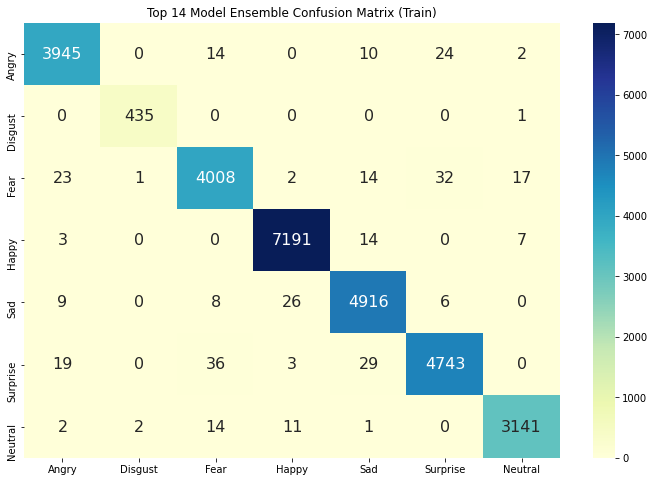

Validation Dataset Validation Time: 80.8620
Validation Loss: 1.24704	Validation Accuracy: 0.75188


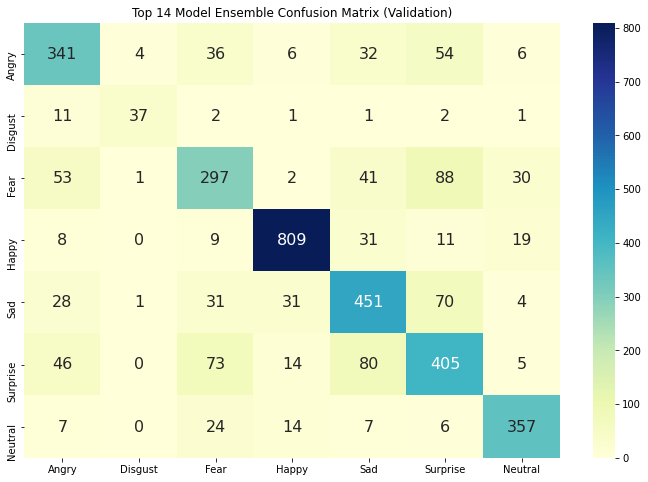

Test Dataset Validation Time: 81.3200
Test Loss: 1.33042	Test Accuracy: 0.73851


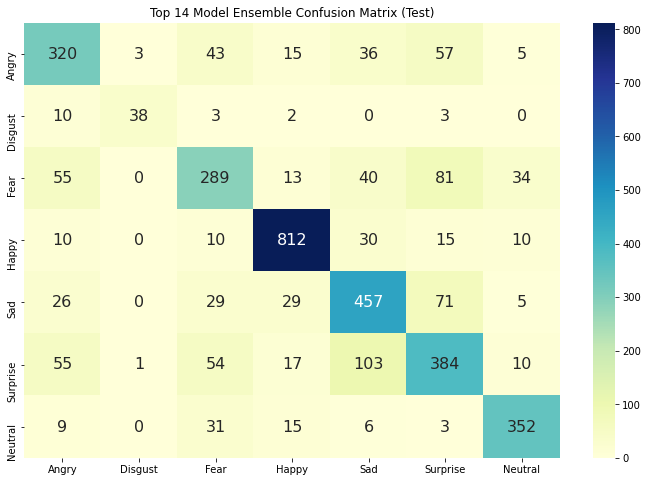

Evaluating Top 15 Model Ensemble
Selected Models: ['ResNeXt101', 'Wide_ResNet101', 'DenseNet161', 'DenseNet201', 'Wide_ResNet50', 'DenseNet169', 'ResNet34', 'DenseNet121', 'ResNeXt50', 'ResNet50', 'ResNet152', 'ResNet101', 'ResNet18', 'VGG19', 'VGG13']
Train Dataset Validation Time: 662.2072
Train Loss: 0.14246	Train Accuracy: 0.98746


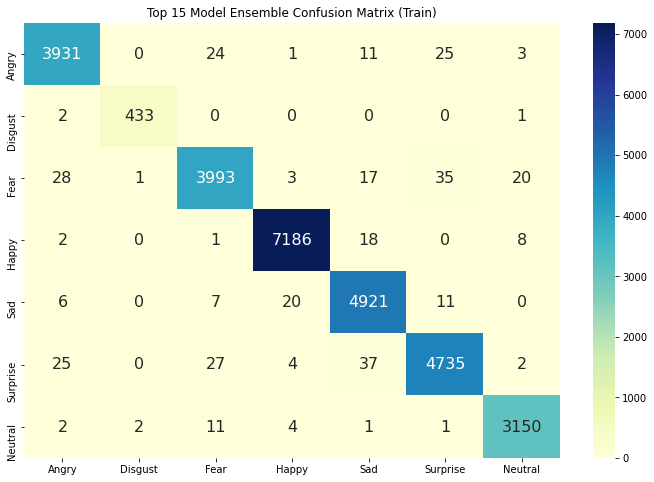

Validation Dataset Validation Time: 85.3635
Validation Loss: 1.23592	Validation Accuracy: 0.75300


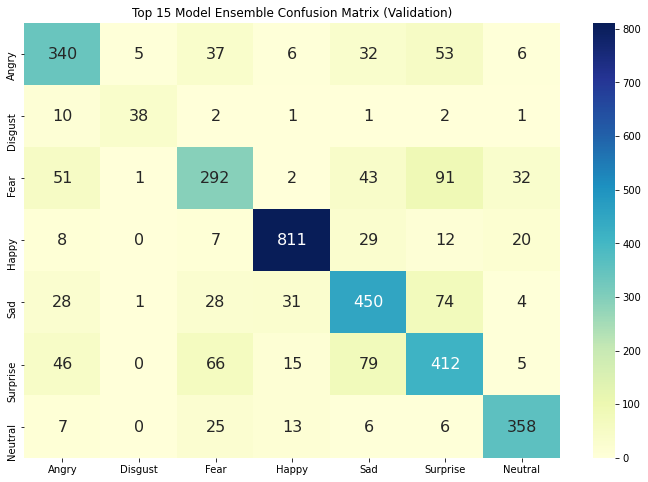

Test Dataset Validation Time: 85.4610
Test Loss: 1.31946	Test Accuracy: 0.73573


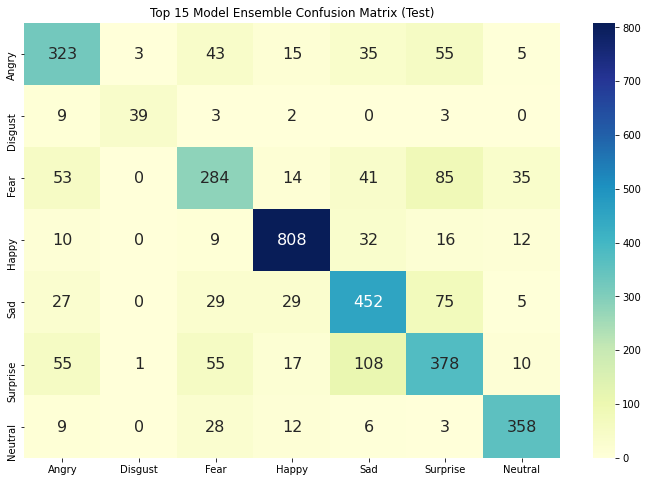

Evaluating Top 16 Model Ensemble
Selected Models: ['ResNeXt101', 'Wide_ResNet101', 'DenseNet161', 'DenseNet201', 'Wide_ResNet50', 'DenseNet169', 'ResNet34', 'DenseNet121', 'ResNeXt50', 'ResNet50', 'ResNet152', 'ResNet101', 'ResNet18', 'VGG19', 'VGG13', 'VGG11']
Train Dataset Validation Time: 683.2821
Train Loss: 0.15080	Train Accuracy: 0.98575


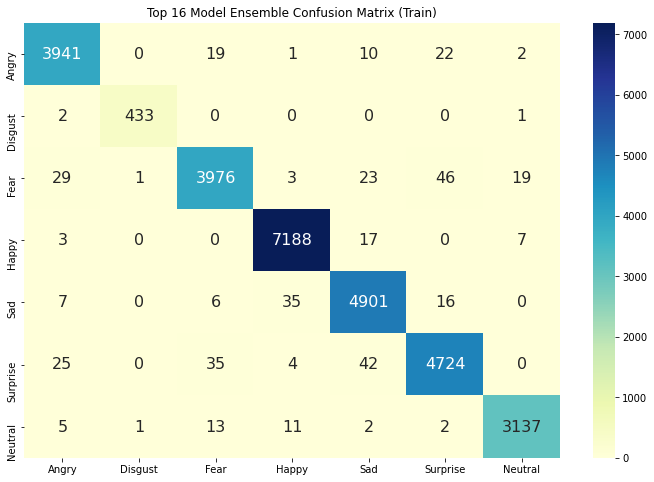

Validation Dataset Validation Time: 87.6476
Validation Loss: 1.22821	Validation Accuracy: 0.75188


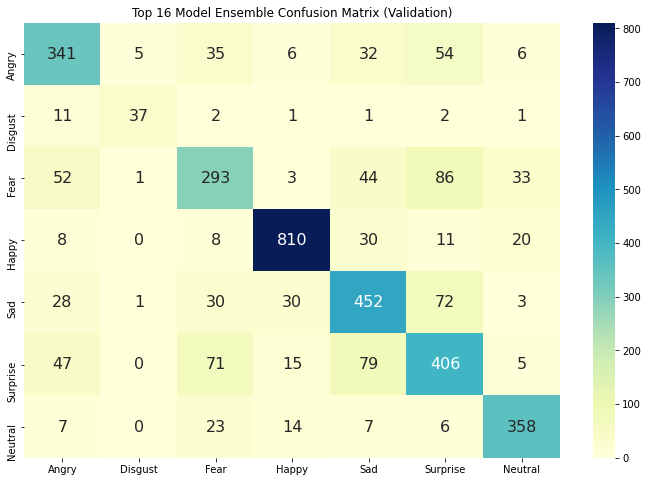

Test Dataset Validation Time: 87.9043
Test Loss: 1.31230	Test Accuracy: 0.73712


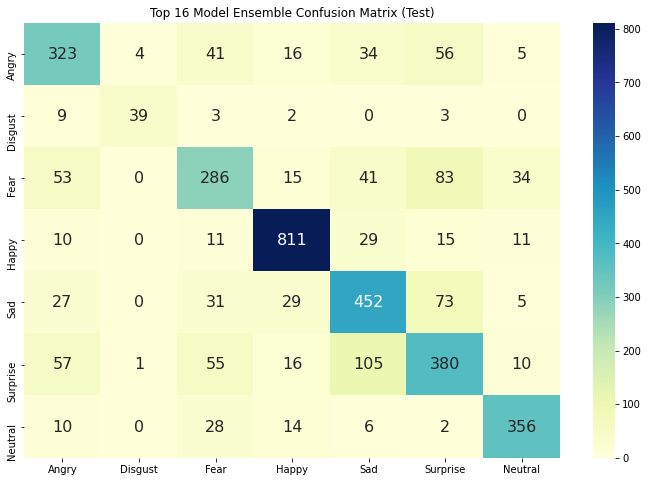

Evaluating Top 17 Model Ensemble
Selected Models: ['ResNeXt101', 'Wide_ResNet101', 'DenseNet161', 'DenseNet201', 'Wide_ResNet50', 'DenseNet169', 'ResNet34', 'DenseNet121', 'ResNeXt50', 'ResNet50', 'ResNet152', 'ResNet101', 'ResNet18', 'VGG19', 'VGG13', 'VGG11', 'VGG16']
Train Dataset Validation Time: 723.2477
Train Loss: 0.15498	Train Accuracy: 0.98582


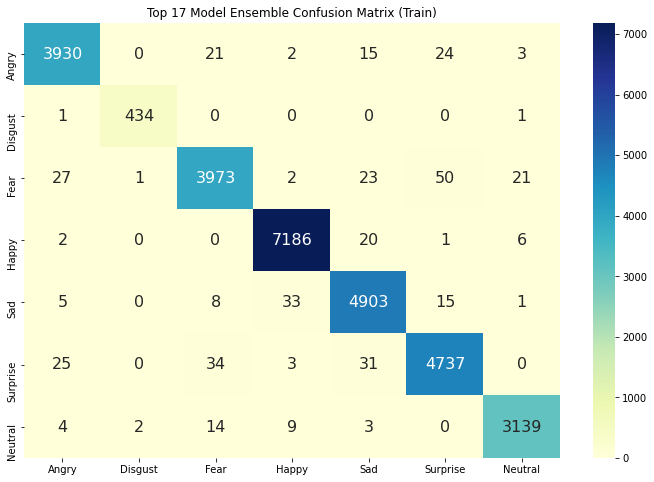

Validation Dataset Validation Time: 92.5503
Validation Loss: 1.22108	Validation Accuracy: 0.75216


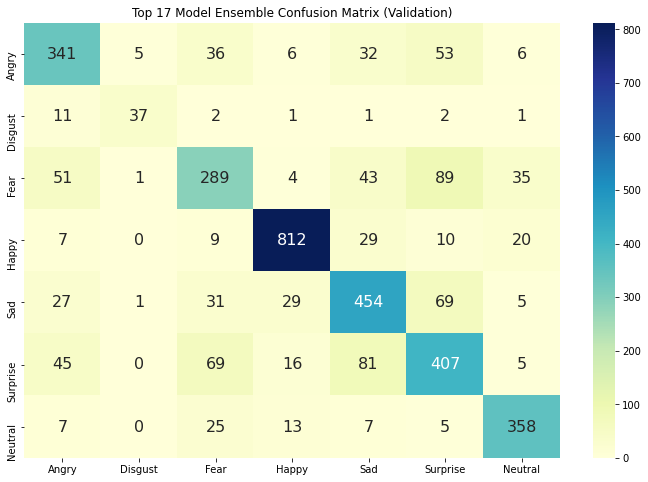

Test Dataset Validation Time: 92.9390
Test Loss: 1.30519	Test Accuracy: 0.73573


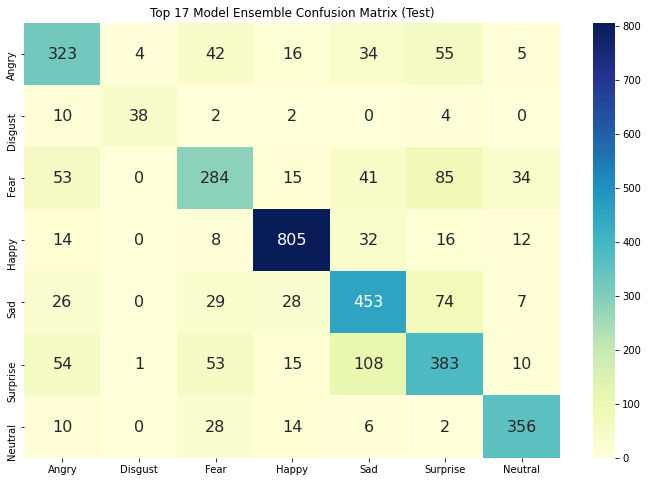

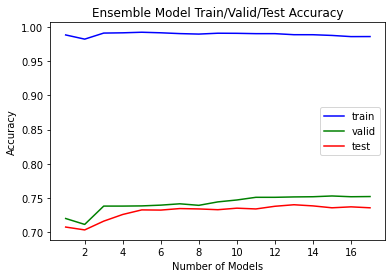

In [36]:
criterion = nn.CrossEntropyLoss()
empty_cache = True
train_acc = []
val_acc = []
test_acc = []
for i in range(1, 18):
    print('Evaluating Top {} Model Ensemble'.format(i))
    selected_models = sorted_models[:i]
    print('Selected Models:', selected_models)
    selected_model_list = {k:v for k,v in model_list.items() if k in selected_models}
    loss, acc, matrix = valid_mode_ensemble(selected_model_list, train_loader, criterion, device, 'Train Dataset', empty_cache)
    train_acc.append(acc)
    print('Train Loss: {:.5f}\tTrain Accuracy: {:.5f}'.format(loss, acc))
    plot_matrix(matrix, 'Train', 'Top {} Model Ensemble'.format(i))
    loss, acc, matrix = valid_mode_ensemble(selected_model_list, dev_loader, criterion, device, 'Validation Dataset', empty_cache)
    val_acc.append(acc)
    print('Validation Loss: {:.5f}\tValidation Accuracy: {:.5f}'.format(loss, acc))
    plot_matrix(matrix, 'Validation', 'Top {} Model Ensemble'.format(i))
    loss, acc, matrix = valid_mode_ensemble(selected_model_list, test_loader, criterion, device, 'Test Dataset', empty_cache)
    test_acc.append(acc)
    print('Test Loss: {:.5f}\tTest Accuracy: {:.5f}'.format(loss, acc))
    plot_matrix(matrix, 'Test', 'Top {} Model Ensemble'.format(i))

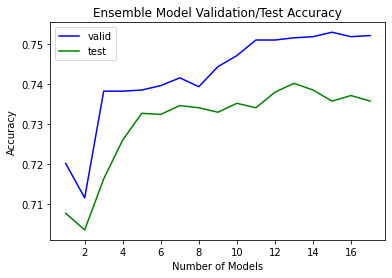

In [38]:
plot_ensembles(val_acc, test_acc)

In [44]:
acc = [train_acc, val_acc, test_acc]
acc_df = pd.DataFrame(acc, index=['Training Accuracy', 'Validation Accuracy', 'Testing Accuracy'], columns=['Top {} Model Ensemble'.format(i) for i in range(1, 18)])
acc_df.to_csv('/content/gdrive/My Drive/ensemble_accuracy.csv')